<img src="./figs/Logos.png" alt="drawing"/>

# Clay Conference 2024 - Scientific Support Programme: From Equations to Simulations: An interactive introduction to a numerical fluid flow implementation: Part 2 - transient fluid flow

by M. Pitz and Th. Nagel

In [27]:
# Some extra useful libraries that need to be
# imported first so that python can perform 
# the desired numerical computations (numpy)
# as well as produce some nice figures (matplotlib)

import numpy as np
import matplotlib.pyplot as plt

# Introduction

In the previous script, we have discretized the ordinary differential equation $\mathrm{div} (\mathbf{A}) = 0$ and numerially solved it, i.e. found an approximate solution using the finite volume method. We have used the notation $\mathrm{div}_n (\mathbf{A})$ to indicate that the equation was approximated by FVM around each considered volume $V_n$. The solution to this differential equation was entirely governed by the applied boundary conditions, so any change to the BCs would immidiatly change the solution at every volume in the domain (we solved a so-called elliptic equation). 

In this second script, we consider storage terms, which have a "dampening" effect on the system. This means that time-dependent changes of BCs no longer imply that the pressure field in the entire domain changes instantaneously with the BC. It also means, that our differential equation now contains partial derivatives with respect to time $t$ into account instead of only location $x$ as previously. Time-dependent simulations are called transient. In the long-term, the transient state of the system may or may not tend towards a steady state, where the pressure at each point in the domain does not change with time anymore. If this is the case, the rate term becomes zero and the solution of the PDE is given only by the flow terms, i.e. the solution will be identical to our steady-state solution from the last script.

Let us start by quickly re-defining some properties that we have already discussed in the last script. We will plot them so that if we play around with them, we can see the effects. We start with:

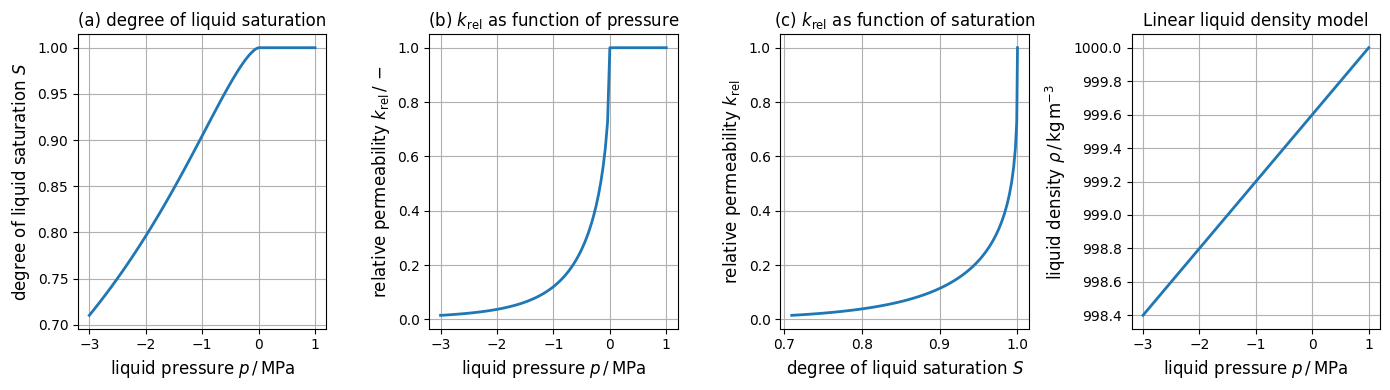

In [28]:
###################
# 1D discretization
###################

L = 1.0 # length of 1D domain in m
num_volumes = 101 # discretisation into N volumes
l = L/(num_volumes - 1) # distance between centres of two neighbouring volumes


###################
# Define functions
###################

# define a function calculating the effective permeability
def rho_times_k_eff(p):
    mu = 5.0e-4 # liquid viscosity / Pa s
    k_int = 1.0e-18 # intrinsic permeability / m^2
    return - rho(p) * k_rel(p) * k_int / mu

# properties defining the relative liquid 
# permeability and degree of liquid saturation,
# defined as functions of the liquid pressure,
# both according to van Genuchten (1980) and Mualem (19XX)

n = 1.49 # van Genuchten n
pe = 2.0e06 # van Genuchten entry pressure

# define function calculating the relative permeability 
# of liquid as a function of of liquid pressure
def k_rel(p):
    m = 1-1/n
    return np.sqrt(S(p)) * np.power(1-(np.power(1-np.power(S(p),1/m),m)),2)

# define a function calculating the degree of liquid
# saturation as a function of liquid pressure
def S(p):
    if p < 0.0:
        return np.power(1+np.power(-p/pe,n),(1/n)-1)
    else:
        return 1.0

# define a function calculating the liquid pressure
# as a function of the liquid pressure
def rho(p):
    p_ref = 1.0e06   # reference liquid pressure / Pa
    beta_p = 4.0e-10 # liquid compressibility / Pa^-1
    rho_ref = 1000.0 # reference liquid density / kg m^-3
    return rho_ref * (1+beta_p*(p-p_ref))  

###################
# Plot functions
###################

pressure = np.linspace(-3e6,1e6, 101) # define a liquid pressure range
saturation = [S(p) for p in pressure] # calculate corresp. saturations
rel_permeability = [k_rel(p) for p in pressure] # calculate corresp. relperms
density = [rho(p) for p in pressure] # calculate corresp. liquid densities

# some plot settings
width = 2 # line width
fsize = 12 # font size

# plot saturation
fig1 = plt.figure(figsize=(14,4))
plt.subplot(1,4,1)
plt.plot(pressure/1e6, saturation, linewidth = width) # plot
plt.grid()
plt.xlabel(r"liquid pressure $p \, / \, \mathrm{MPa}$", fontsize = fsize)
plt.ylabel(r"degree of liquid saturation $S$", fontsize = fsize)
plt.title(r"(a) degree of liquid saturation", fontsize = fsize)

# plot relative permeability as function of liquid pressure
plt.subplot(1,4,2)
plt.plot(pressure/1e6, rel_permeability, linewidth = width) # plot
plt.xlabel(r"liquid pressure $p \, / \, \mathrm{MPa}$", fontsize = fsize)
plt.ylabel(r"relative permeability $k_\mathrm{rel} \, / \, -$", fontsize = fsize)
plt.title(r"(b) $k_\mathrm{rel}$ as function of pressure", fontsize = fsize)
plt.grid()

# plot relative permeability as function of liquid saturation
plt.subplot(1,4,3)
plt.plot(saturation, rel_permeability, linewidth = width) # plot
plt.xlabel(r"degree of liquid saturation $S$", fontsize = fsize)
plt.ylabel(r"relative permeability $k_\mathrm{rel}$", fontsize = fsize)
plt.title(r"(c) $k_\mathrm{rel}$ as function of saturation", fontsize = fsize)
plt.grid()

plt.subplot(1,4,4)
plt.plot(pressure/1e6, density, linewidth = width) # plot
plt.grid()
plt.xlabel(r"liquid pressure $p \, / \, \mathrm{MPa}$", fontsize = fsize)
plt.ylabel(r"liquid density $\rho \, / \, \mathrm{kg} \, \mathrm{m}^{-3}$", fontsize = fsize)
plt.title(r"Linear liquid density model", fontsize = fsize)

fig1.tight_layout()

Now, let us consider the principle of the storage term, which describes that the amount of mass (of the liquid) in the porous medium can change over time. We follow the theory of porous media in order to describe the liquid mass present in each control volume. This means that we will not represent the microscropic structure of pores or solid particles, but instead use up-scaled descriptions of a porous medium such as porosity and degree of liquid saturation to describe properties of the volume that are locally statistically representative:

<img src="./figs/REV_Class.PNG" alt="drawing" width="800"/>

Using this theory, we can include the change of liquid mass in our control volume in the PDE describing the conservation of mass with

\begin{equation}
 0 = \frac{\mathrm{d} m_n}{\mathrm{d} t} + \mathrm{div}_n \, \left( \mathbf{A} \right) \, ,
\end{equation}

where $m_n$ represents the mass of the liquid present in the control volume. Using the medium porosity $\phi$ , the degree of liquid saturation $S$, the volume of the respective finite volume $V_{\mathrm{REV,}n}$ and the liquid density $\rho$, we can substitute the liquid mass and arrive at:

\begin{equation}
 0 = \frac{\mathrm{d} \rho V \phi S}{\mathrm{d} t} + \mathrm{div}_n \, \left( \mathbf{A} \right) 
\end{equation}

Since we regard $V$ and $\phi$ as constants in this script, they can be factored out, and the product rule is applied to the derivative, leading to:

\begin{equation}
 0 = \phi V \left( S\frac{\mathrm{d} \rho}{\mathrm{d} t} + \rho \frac{\mathrm{d} S}{\mathrm{d} t}\right) + \mathrm{div}_n \, \left( \mathbf{A} \right) 
\end{equation}

As before, we want to express all terms in terms of a single unknown, the liquid pressure $p$, in order to construct the matrix representation later on. the density $\rho$ and the degree of liquid saturation $S$ are functions of $p$, so that we can apply the chain rule to get:

\begin{equation}
 0 = \phi V \left( S \frac{\partial \rho}{\partial p} \frac{\mathrm{d} p}{\mathrm{d} t} + \rho \frac{\partial S}{\partial p} \frac{\mathrm{d} p}{\mathrm{d} t} \right) + \mathrm{div}_n \, \left( \mathbf{A} \right) 
\end{equation}

where we factor out $\frac{\mathrm{d} p}{\mathrm{d} t}$ to get the final PDE with

\begin{equation}
 0 = \underbrace{\phi V \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p} \right)}_{\mathrm{storage \, term}} \frac{\mathrm{d} p}{\mathrm{d} t} + \mathrm{div}_n \, \left( \mathbf{A} \right) 
\end{equation}

In our 1D model, we assume a cross-sectional area of 1 m$^2$, so that we can say $V = l \cdot 1\,$m$^2$. With the functions for $S$ and $\rho$ defined above, one could define also their partial derivatives with regard to $p$, but one can also use numerical differentiation using forward or central differences, for example, which makes life easier in case one wants to change the density or suction curves:

In [29]:
def dfdp(function,p):
    epsilon = p/1e7
    return (function(p+epsilon)-function(p-epsilon))/(2*epsilon)

Now, we can write a function that calculates the storage term as defined in the equation above. 

In [30]:
def storage(p):
    phi = 0.2
    return l*phi*(dfdp(rho,p)*S(p) + rho(p)*dfdp(S,p))

Now, we need to treat the temporal derivative of the pressure $\frac{\mathrm{d}p}{\mathrm{d}t}$. It describes the change of pressure at every point, or, in the discretized model, in every control volume. Given an initial pressure distribution, calculating $\frac{\mathrm{d}p}{\mathrm{d}t}$ in every volume is exactly what we need to predict the evolution of the pressure. We can use the definition of differentiation, without applying the infinitesimal limit, to approximate the derivative. Let us assume that we already know the pressure in the volume $V_n$ at time $t=t_0$, denoted with $p_n^{0}$. We keep track of the time step, i.e. the temporal discretization, using the superscript, because we are already using subscripts to keep track of the volumes, i.e. the spatial distretization. We can then define the temporal derivative based on the pressure $p_n^{t1}$ at the next time step $t=t_1$. This approximation is called the Euler method:

\begin{equation}
    \frac{\mathrm{d}p}{\mathrm{d}t} = \frac{p_n^{t1} - p_n^{t0}}{\Delta t}
\end{equation}

where $\Delta t = t_1-t_0$ is the finite time step size (i.e. a constant during the calculation of a given time step). We can now see that finding a $p_n^{t1}$, gives us our desired solution, a.k.a. the pressure in the control volume at the next time step. Let us insert this formulation into the PDE:

\begin{equation}
    0 =  \left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right] \frac{p_n^{t1} - p_n^{t0}}{\Delta t} + \mathrm{div}_n \, \left( \mathbf{A} \right) 
\end{equation}

We now have to ask ourselves whether we want to evaluate the storage term as well as $\mathrm{div}_n$ at the time $t_0$ or $t_1$. If we evaluate both at $t=t_0$, then each term is fully determined from the pressure distribution at the respective point in time -- they are constants ($\mathrm{div}_n$ could be evaluated analogously to the ```analyse_mass_balance()``` function used in the jupyter notebook dealing with the steady state solution). We would then rearrange the equation above with 

\begin{equation}
     p_n^{t1} =  p_n^{t0} - \frac{\mathrm{div}_n^{t0} \, \left( \mathbf{A} \right)}{\left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]^{t0}} \Delta t
\end{equation}

This is called the "forward Euler" or "explicit Euler method" and it is straight forward to implement -- no need for solving linear equation systems. However, one can see that especially for large time step sizes $\Delta t$, the solution can be unstable and "overshoot" the actual temporal evolution. However, this "explicit" statement for how $p_n^{t1}$ allows to see immediately how the system evolves: 
* We remember from the last script that a $\mathrm{div}_n < 0$ implies generally flow towards the control volume $V_n$. With the given definitions, $\left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]$ is always greater than zero (you can confirm by checking the saturation and density functions of pressure). Therefore, the equation above shows that in case of flow towards the control volume $V_n$, the respective liquid pressure must increase.
* With a given value for $\mathrm{div}_n$  storage term scales the pressure increase from the previous bullet point. A high value for $\left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]^{t0}$ could be the result of a large volume, a large porosity, a highly compressible fluid or a high suction potential, all of which would hence dampen the pressure increase.
* The time step size has the opposite scaling effect as the storage. We can see that pressure changes increase with time step size. Seeing that the value for $\Delta t$ is not a matter of physics but of resolution of time (so, a numerical choice), one can see that a suitable and appropriate choice is essential here.

Now, let us consider another option, which is evaluating the storage term as well as $\mathrm{div}_n$ at the time $t_1$. Since we are trying to find the pressure distribution at $t = t_1$, we cannot calculate them directly, instead we seek a pressure distribution that satisfies the equation

\begin{equation}
     p_n^{t1} =  p_n^{t0} - \frac{\mathrm{div}_n^{t1} \, \left( \mathbf{A} \right)}{\left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]^{t1}} \Delta t
\end{equation}

This is called the "backward Euler" or "implicit Euler Method", because is does not explicitely tell us what $p_n^{t1}$ will be because it is still contained in the divergence term on the right-hand side. We need to solve the non-linear equation system for that. This is of course more expensive computationally. However, the implicit method is generally more stable, and can handle large time step sizes better.

Therefore, many numerical codes used in the field employ implicit methods for the time descretization. We proceed similarly to the last time by taking a look at the linearized equation system. Recalling the discritization of $0=\mathrm{div}_n \, \left( \mathbf{A} \right)$ from the steady-state script and adding to the notation a superscrip $t1$ to keep track of the point in time at which the divergence term is evaluated, we can simply add the new storage terms to the equation system. The constant part (i.e. independent of $p^{t1}$ can be moved over to the other side of the equation:

\begin{alignat}{1}
\begin{split}
    \\
    \text{For Volume } V_0:&\\
    \\
    \left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]_0^{t1} \frac{p_0^{t0}}{\Delta t} &= \left[ \frac{\rho \left( \tilde{p}_0^{\,\mathrm{right}} \right) k_\mathrm{eff} \left( \tilde{p}_0^{\,\mathrm{right}} \right)}{l} + \frac{\left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]_0^{t1}}{\Delta t} \right] \, p_0^{t1} - \frac{\rho \left( \tilde{p}_0^{\,\mathrm{right}} \right) k_\mathrm{eff} \left( \tilde{p}_0^{\,\mathrm{right}} \right)}{l} \, p_{1}^{t1}  \\
    \\
    \\
    \text{For Volume } V_n:&\\
    \\
    \left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]_n^{t1} \frac{p_n^{t0}}{\Delta t} &= - \frac{\rho \left( \tilde{p}_n^{\,\mathrm{left}}\right) k_\mathrm{eff} \left( \tilde{p}_n^{\, \mathrm{left}} \right)}{l} \, p_{n-1}^{t1}  + \left[\frac{\rho \left( \tilde{p}_n^{\,\mathrm{left}}\right) k_\mathrm{eff} \left( \tilde{p}_n^{\,\mathrm{left}} \right) + \rho \left( \tilde{p}_n^{\,\mathrm{right}} \right) k_\mathrm{eff} \left( \tilde{p}_n^{\,\mathrm{right}} \right) }{l} + \frac{ \left( \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right)_n^{t1}}{\Delta t} \right] \, p_n^{t1}  - \frac{\rho \left( \tilde{p}_n^{\,\mathrm{right}} \right) k_\mathrm{eff} \left( \tilde{p}_n^{\, \mathrm{right}} \right)}{l} \, p_{n+1}^{t1}  \\
    \\
    \\
    \text{For Volume } V_N:&\\
    \\
    \left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]_N^{t1} \frac{p_N^{t0}}{\Delta t} &= - \frac{\rho \left( \tilde{p}_N^{\,\mathrm{left}}\right) k_\mathrm{eff} \left( \tilde{p}_N^{\,\mathrm{left}} \right)}{l} \, p_{N-1}^{t1}  + \left[ \frac{\rho \left( \tilde{p}_N^{\,\mathrm{left}}\right) k_\mathrm{eff} \left( \tilde{p}_N^{\,\mathrm{left} }\right)}{l} + \frac{\left[ \phi V  \left( S \frac{\partial \rho}{\partial p} + \rho \frac{\partial S}{\partial p}\right) \right]_N^{t1}}{\Delta t} \right] \, p_N^{t1} \\
\end{split}
\end{alignat}


Hence, we can reuse most of the functionality we had defined in the steady-state script (refer to that script for more details). We have defined the storage function above, so that we can add the storage to the matrix coefficients. We also modify the input of the ```compute_matrix_coefficients()``` function, because we need the time step size as well:

In [31]:
def compute_matrix_coefficients(p_vector, dt):
    matrix = np.zeros([len(p_vector), len(p_vector)]) # initialize a matrix of zeros with
                                                      # correct number of rows and columns    
    for i,p in enumerate(p_vector):
        if i == 0:  # Special treatment for the first volume (left boundary)
            p_right = (p_vector[i] + p_vector[i+1]) / 2  # average pressure on the right
            matrix[i, i]   = storage(p)/dt \
                            -rho_times_k_eff(p_right) / l         # central contribution
            matrix[i, i+1] = rho_times_k_eff(p_right) / l          # right contribution
            
        elif i == len(p_vector) - 1:  # Special treatment for the last volume (right boundary)
            p_left = (p_vector[i-1] + p_vector[i]) / 2  # average pressure on the left
            matrix[i, i-1] = rho_times_k_eff(p_left) / l           # left contribution
            matrix[i, i]   = storage(p)/dt \
                            -rho_times_k_eff(p_left) / l          # central contribution
            
        else:  # General case for interior volumes
            p_left = (p_vector[i-1] + p_vector[i]) / 2   # average pressure on the left
            p_right = (p_vector[i] + p_vector[i+1]) / 2  # average pressure on the right
            matrix[i, i-1] = rho_times_k_eff(p_left) / l           # left contribution
            matrix[i, i]   = storage(p)/dt \
                            -(rho_times_k_eff(p_left) + rho_times_k_eff(p_right)) / l  # central contribution
            matrix[i, i+1] = rho_times_k_eff(p_right) / l          # right contribution

    return matrix

In the last script, the "right hand side" contained only zeros (without any boundary conditions). This time, we must implement a function that creates the rhs which contains the $p^{t0}$ part of the storage term. This function has to take as input the pressure vector from the previous time step:

In [32]:
def compute_rhs(p_curr, p_prev_ts, dt):
    rhs = np.zeros(len(p_prev_ts))
    for i,p in enumerate(p_prev_ts):
        rhs[i] = storage(p_curr[i])*p/dt
    return rhs

Many other functions we had defined, remain entirely unchanged from the functions, we had used for the steady-state script, namely:
* The function applying the boundary conditions ```apply_BCs()```
* The function solving the linear equation system ```solve_linear_equation_system()``` 
* The function performing the Picard iterations ```iterate_solution()```
* The function checking the convergence criterion ```check_convergence()```

In [33]:
def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Left boundary: Set entire first row to 0, then set the diagonal element to 1
    matrix[0, :] = 0
    matrix[0, 0] = 1
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] = -2.0e6  # Left boundary value in MPa
    rhs[-1] = 1.0e6  # Right boundary value in MPa
    
    return matrix, rhs

def solve_linear_equation_system(p_vector, p_prev_ts, dt):
    matrix = compute_matrix_coefficients(p_vector, dt)  # create the matrix containing 
                                                        # all hydraulic coefficients
    rhs = compute_rhs(p_vector,p_prev_ts, dt)                    # create the "right hand side" vector
    matrix, rhs = apply_BCs(matrix, rhs)                # modify the matrix and rhs to
                                                        # apply the boundary conditions
    return np.linalg.solve(matrix, rhs)                 # Numpy's function solving the
                                                        # defined linear equation system
    
def iterate_solution(p_prev_ts, dt):
    max_iterations = 100
    solution_last_iteration = p_prev_ts
    iterations = 0
    convergence_crit = False
    while convergence_crit == False:
        if iterations > max_iterations:
            print('Max iterations exceeded.')
            print('Stopping iteration scheme.')
            break
        iterations = iterations + 1
        new_solution = solve_linear_equation_system(solution_last_iteration, p_prev_ts, dt)
        convergence_crit = check_convergence(new_solution, solution_last_iteration)
        solution_last_iteration = new_solution
    print("Performed {} iterations in total".format(iterations))
    return new_solution


def check_convergence(new_solution, solution_last_iteration):
    dx = np.linalg.norm(new_solution-solution_last_iteration)
    x = np.linalg.norm(new_solution)
    relative_change = dx/x
    relative_epsilon = 1.0e-6
    print("convergence criterion"
          ": |dx|=",     np.format_float_scientific(dx, precision=3), \
          "; |x|=",      np.format_float_scientific(x, precision=3),\
          "; |dx|/|x|=", np.format_float_scientific(relative_change, precision=3))
    if relative_change <= relative_epsilon:
        return True
    else:
        return False

Now, we need a function that runs the simulation. It works as follows:
  1. it creates global dictionaries containing the results that we can access for plotting purposes
  2. It initializes the starting time, the initial time step size, and defines a given initial pressure distribution and initial time as first entries in the result dictionaries
  3. It enters a loop that will be repeated for each time step, until we arrive at the end time. In this loop, the procedure is quite similar to the steady state script again, with a few additions to keep track of the time stepping.
     * In each time step, first the time and time step tracker are adjusted.
     * Next, some info is printed and then, the equation system is solved with the given dt. It takes as input the pressure field from the previous time step
     * The global time is saved as well 
     * The time step size is increased for the next time step
     
And this is it!

In [40]:
def run_simulation():
    global solution_time_step
    global times_lookup_table
    times_lookup_table = {}
    solution_time_step = {}
    times_lookup_table = {}
    global_time = 0.0 # initialize starting time
    dt = 1.0e03 # initial time step size
    end_time = 1.0e07 #3600*24*365/6 # 1 year
    ts = 0 # time step counter
    solution_time_step[ts] = np.linspace(-2e6,-2e6,num_volumes) # initial pressure vector
    times_lookup_table[ts] = global_time     # and global time dictionary
    while global_time < end_time:     # Loop for each time step
        ts = ts+1 # increase time step counter
        global_time = global_time + dt # increase time tracker
        print("Time Step", ts, \
              "with global time", np.format_float_scientific(global_time, precision=3), \
              "s and step size", np.format_float_scientific(dt, precision=3), "s")
        solution_time_step[ts] = iterate_solution(solution_time_step[ts-1], dt) # solve equation system for this time step
        times_lookup_table[ts] = global_time # save the time corresponding to this time step
        dt = dt*1.05 # increase time step size for next step if desired
    print("Finito :-)!")
    
def make_transient_plots(times_lookup_table, solution_time_step):
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    for i in range(len(times_lookup_table))[0:-1:10]:
        plt.plot(np.linspace(0,1,num_volumes), solution_time_step[i], label = "t={} s".format(np.format_float_scientific(times_lookup_table[i], precision=1)))
    plt.grid()
    plt.legend()
    plt.ylabel(r"pressure $p \, / \, \mathrm{Pa}$")
    plt.xlabel(r"distance $x \, / \, \mathrm{m}$")
    plt.title(r"Plots over the $x$ coordinate at time $t$")

    plt.subplot(1,2,2)
    for x in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        V_x = int(num_volumes * x)
        p_x = []
        for i in range(len(times_lookup_table)):
            p_x.append(solution_time_step[i][V_x])
        plt.plot([t for t in times_lookup_table], p_x, label = "$x = ${} m ".format(x))
    plt.grid()
    plt.title(r"Plots over the time $t$ at $x$ coordinate")
    #plt.ylabel(r"pressure $p \, / \, \mathrm{Pa}$")
    plt.xlabel(r"time $t \, / \, \mathrm{s}$")
    plt.legend()

In [41]:
run_simulation()

Time Step 1 with global time 1.e+03 s and step size 1.e+03 s
convergence criterion: |dx|= 3.002e+06 ; |x|= 2.001e+07 ; |dx|/|x|= 1.5e-01
convergence criterion: |dx|= 5.345e+05 ; |x|= 1.997e+07 ; |dx|/|x|= 2.677e-02
convergence criterion: |dx|= 2.336e+05 ; |x|= 1.995e+07 ; |dx|/|x|= 1.171e-02
convergence criterion: |dx|= 1.887e+05 ; |x|= 1.994e+07 ; |dx|/|x|= 9.464e-03
convergence criterion: |dx|= 2.843e+05 ; |x|= 1.993e+07 ; |dx|/|x|= 1.427e-02
convergence criterion: |dx|= 2.303e+04 ; |x|= 1.992e+07 ; |dx|/|x|= 1.156e-03
convergence criterion: |dx|= 2.701e+03 ; |x|= 1.992e+07 ; |dx|/|x|= 1.356e-04
convergence criterion: |dx|= 3.771e+02 ; |x|= 1.992e+07 ; |dx|/|x|= 1.892e-05
convergence criterion: |dx|= 5.645e+01 ; |x|= 1.992e+07 ; |dx|/|x|= 2.833e-06
convergence criterion: |dx|= 8.646e+00 ; |x|= 1.992e+07 ; |dx|/|x|= 4.34e-07
Performed 10 iterations in total
Time Step 2 with global time 2.05e+03 s and step size 1.05e+03 s
convergence criterion: |dx|= 7.324e+05 ; |x|= 1.99e+07 ; |dx|/|x

convergence criterion: |dx|= 3.793e+03 ; |x|= 1.783e+07 ; |dx|/|x|= 2.126e-04
convergence criterion: |dx|= 7.555e+02 ; |x|= 1.783e+07 ; |dx|/|x|= 4.236e-05
convergence criterion: |dx|= 5.626e+02 ; |x|= 1.783e+07 ; |dx|/|x|= 3.154e-05
convergence criterion: |dx|= 3.165e+02 ; |x|= 1.783e+07 ; |dx|/|x|= 1.775e-05
convergence criterion: |dx|= 5.879e+01 ; |x|= 1.783e+07 ; |dx|/|x|= 3.296e-06
convergence criterion: |dx|= 4.877e+01 ; |x|= 1.783e+07 ; |dx|/|x|= 2.735e-06
convergence criterion: |dx|= 2.595e+01 ; |x|= 1.783e+07 ; |dx|/|x|= 1.455e-06
convergence criterion: |dx|= 4.671e+00 ; |x|= 1.783e+07 ; |dx|/|x|= 2.619e-07
Performed 14 iterations in total
Time Step 57 with global time 3.027e+05 s and step size 1.537e+04 s
convergence criterion: |dx|= 3.371e+05 ; |x|= 1.78e+07 ; |dx|/|x|= 1.894e-02
convergence criterion: |dx|= 1.877e+05 ; |x|= 1.778e+07 ; |dx|/|x|= 1.056e-02
convergence criterion: |dx|= 7.468e+04 ; |x|= 1.778e+07 ; |dx|/|x|= 4.201e-03
convergence criterion: |dx|= 1.63e+04 ; |x

convergence criterion: |dx|= 3.665e+03 ; |x|= 1.721e+07 ; |dx|/|x|= 2.13e-04
convergence criterion: |dx|= 1.089e+03 ; |x|= 1.721e+07 ; |dx|/|x|= 6.329e-05
convergence criterion: |dx|= 2.434e+02 ; |x|= 1.721e+07 ; |dx|/|x|= 1.415e-05
convergence criterion: |dx|= 1.555e+02 ; |x|= 1.721e+07 ; |dx|/|x|= 9.035e-06
convergence criterion: |dx|= 5.602e+01 ; |x|= 1.721e+07 ; |dx|/|x|= 3.256e-06
convergence criterion: |dx|= 1.897e+01 ; |x|= 1.721e+07 ; |dx|/|x|= 1.103e-06
convergence criterion: |dx|= 9.597e+00 ; |x|= 1.721e+07 ; |dx|/|x|= 5.578e-07
Performed 12 iterations in total
Time Step 66 with global time 4.806e+05 s and step size 2.384e+04 s
convergence criterion: |dx|= 3.702e+05 ; |x|= 1.716e+07 ; |dx|/|x|= 2.158e-02
convergence criterion: |dx|= 2.123e+05 ; |x|= 1.713e+07 ; |dx|/|x|= 1.239e-02
convergence criterion: |dx|= 9.515e+04 ; |x|= 1.713e+07 ; |dx|/|x|= 5.554e-03
convergence criterion: |dx|= 2.949e+04 ; |x|= 1.713e+07 ; |dx|/|x|= 1.722e-03
convergence criterion: |dx|= 5.546e+03 ; |

convergence criterion: |dx|= 1.478e+01 ; |x|= 1.65e+07 ; |dx|/|x|= 8.961e-07
Performed 12 iterations in total
Time Step 74 with global time 7.197e+05 s and step size 3.522e+04 s
convergence criterion: |dx|= 4.039e+05 ; |x|= 1.644e+07 ; |dx|/|x|= 2.457e-02
convergence criterion: |dx|= 2.335e+05 ; |x|= 1.640e+07 ; |dx|/|x|= 1.424e-02
convergence criterion: |dx|= 1.071e+05 ; |x|= 1.640e+07 ; |dx|/|x|= 6.529e-03
convergence criterion: |dx|= 2.659e+04 ; |x|= 1.64e+07 ; |dx|/|x|= 1.622e-03
convergence criterion: |dx|= 6.304e+03 ; |x|= 1.64e+07 ; |dx|/|x|= 3.845e-04
convergence criterion: |dx|= 3.189e+03 ; |x|= 1.64e+07 ; |dx|/|x|= 1.945e-04
convergence criterion: |dx|= 7.991e+02 ; |x|= 1.64e+07 ; |dx|/|x|= 4.874e-05
convergence criterion: |dx|= 2.381e+02 ; |x|= 1.64e+07 ; |dx|/|x|= 1.452e-05
convergence criterion: |dx|= 1.179e+02 ; |x|= 1.64e+07 ; |dx|/|x|= 7.192e-06
convergence criterion: |dx|= 4.734e+01 ; |x|= 1.64e+07 ; |dx|/|x|= 2.887e-06
convergence criterion: |dx|= 2.036e+01 ; |x|= 1.6

convergence criterion: |dx|= 1.773e+03 ; |x|= 1.56e+07 ; |dx|/|x|= 1.137e-04
convergence criterion: |dx|= 3.164e+02 ; |x|= 1.56e+07 ; |dx|/|x|= 2.029e-05
convergence criterion: |dx|= 2.288e+02 ; |x|= 1.56e+07 ; |dx|/|x|= 1.467e-05
convergence criterion: |dx|= 8.538e+01 ; |x|= 1.56e+07 ; |dx|/|x|= 5.474e-06
convergence criterion: |dx|= 2.359e+01 ; |x|= 1.56e+07 ; |dx|/|x|= 1.513e-06
convergence criterion: |dx|= 1.326e+01 ; |x|= 1.56e+07 ; |dx|/|x|= 8.503e-07
Performed 12 iterations in total
Time Step 82 with global time 1.073e+06 s and step size 5.204e+04 s
convergence criterion: |dx|= 4.426e+05 ; |x|= 1.552e+07 ; |dx|/|x|= 2.851e-02
convergence criterion: |dx|= 2.536e+05 ; |x|= 1.547e+07 ; |dx|/|x|= 1.639e-02
convergence criterion: |dx|= 1.157e+05 ; |x|= 1.548e+07 ; |dx|/|x|= 7.473e-03
convergence criterion: |dx|= 3.083e+04 ; |x|= 1.547e+07 ; |dx|/|x|= 1.993e-03
convergence criterion: |dx|= 5.944e+03 ; |x|= 1.547e+07 ; |dx|/|x|= 3.843e-04
convergence criterion: |dx|= 3.585e+03 ; |x|= 1

convergence criterion: |dx|= 1.531e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 1.049e-05
convergence criterion: |dx|= 4.976e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 3.410e-05
convergence criterion: |dx|= 3.824e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 2.620e-05
convergence criterion: |dx|= 1.531e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 1.049e-05
convergence criterion: |dx|= 4.976e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 3.41e-05
convergence criterion: |dx|= 3.824e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 2.620e-05
convergence criterion: |dx|= 1.531e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 1.049e-05
convergence criterion: |dx|= 4.976e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 3.41e-05
convergence criterion: |dx|= 3.824e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 2.620e-05
convergence criterion: |dx|= 1.531e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 1.049e-05
convergence criterion: |dx|= 4.976e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 3.41e-05
convergence criterion: |dx|= 3.824e+02 ; |x|= 1.459e+07 ; |dx|/|x|= 2.620e-05
convergence criterion: |dx|= 1.531e+02 ; |x|= 1.459e+07 ; |dx|/|x|=

convergence criterion: |dx|= 1.163e+01 ; |x|= 1.390e+07 ; |dx|/|x|= 8.369e-07
Performed 12 iterations in total
Time Step 93 with global time 1.849e+06 s and step size 8.901e+04 s
convergence criterion: |dx|= 5.038e+05 ; |x|= 1.379e+07 ; |dx|/|x|= 3.653e-02
convergence criterion: |dx|= 2.884e+05 ; |x|= 1.372e+07 ; |dx|/|x|= 2.101e-02
convergence criterion: |dx|= 1.323e+05 ; |x|= 1.373e+07 ; |dx|/|x|= 9.640e-03
convergence criterion: |dx|= 3.664e+04 ; |x|= 1.372e+07 ; |dx|/|x|= 2.671e-03
convergence criterion: |dx|= 6.978e+03 ; |x|= 1.371e+07 ; |dx|/|x|= 5.088e-04
convergence criterion: |dx|= 3.741e+03 ; |x|= 1.371e+07 ; |dx|/|x|= 2.728e-04
convergence criterion: |dx|= 9.794e+02 ; |x|= 1.371e+07 ; |dx|/|x|= 7.142e-05
convergence criterion: |dx|= 2.921e+02 ; |x|= 1.371e+07 ; |dx|/|x|= 2.13e-05
convergence criterion: |dx|= 1.421e+02 ; |x|= 1.371e+07 ; |dx|/|x|= 1.036e-05
convergence criterion: |dx|= 5.828e+01 ; |x|= 1.371e+07 ; |dx|/|x|= 4.25e-06
convergence criterion: |dx|= 2.542e+01 ; |x

convergence criterion: |dx|= 1.23e+01 ; |x|= 1.215e+07 ; |dx|/|x|= 1.012e-06
convergence criterion: |dx|= 5.587e+00 ; |x|= 1.215e+07 ; |dx|/|x|= 4.597e-07
Performed 13 iterations in total
Time Step 101 with global time 2.742e+06 s and step size 1.315e+05 s
convergence criterion: |dx|= 5.535e+05 ; |x|= 1.200e+07 ; |dx|/|x|= 4.612e-02
convergence criterion: |dx|= 3.149e+05 ; |x|= 1.191e+07 ; |dx|/|x|= 2.644e-02
convergence criterion: |dx|= 1.442e+05 ; |x|= 1.191e+07 ; |dx|/|x|= 1.211e-02
convergence criterion: |dx|= 3.947e+04 ; |x|= 1.19e+07 ; |dx|/|x|= 3.318e-03
convergence criterion: |dx|= 7.368e+03 ; |x|= 1.189e+07 ; |dx|/|x|= 6.194e-04
convergence criterion: |dx|= 4.212e+03 ; |x|= 1.189e+07 ; |dx|/|x|= 3.541e-04
convergence criterion: |dx|= 1.119e+03 ; |x|= 1.189e+07 ; |dx|/|x|= 9.41e-05
convergence criterion: |dx|= 3.187e+02 ; |x|= 1.189e+07 ; |dx|/|x|= 2.68e-05
convergence criterion: |dx|= 1.576e+02 ; |x|= 1.189e+07 ; |dx|/|x|= 1.325e-05
convergence criterion: |dx|= 6.280e+01 ; |x|

convergence criterion: |dx|= 1.854e+03 ; |x|= 9.741e+06 ; |dx|/|x|= 1.903e-04
convergence criterion: |dx|= 2.781e+02 ; |x|= 9.741e+06 ; |dx|/|x|= 2.855e-05
convergence criterion: |dx|= 2.23e+02 ; |x|= 9.741e+06 ; |dx|/|x|= 2.289e-05
convergence criterion: |dx|= 6.475e+01 ; |x|= 9.741e+06 ; |dx|/|x|= 6.647e-06
convergence criterion: |dx|= 1.121e+01 ; |x|= 9.741e+06 ; |dx|/|x|= 1.151e-06
convergence criterion: |dx|= 7.951e+00 ; |x|= 9.741e+06 ; |dx|/|x|= 8.163e-07
Performed 12 iterations in total
Time Step 109 with global time 4.060e+06 s and step size 1.943e+05 s
convergence criterion: |dx|= 6.06e+05 ; |x|= 9.535e+06 ; |dx|/|x|= 6.356e-02
convergence criterion: |dx|= 3.478e+05 ; |x|= 9.404e+06 ; |dx|/|x|= 3.698e-02
convergence criterion: |dx|= 1.604e+05 ; |x|= 9.419e+06 ; |dx|/|x|= 1.703e-02
convergence criterion: |dx|= 4.606e+04 ; |x|= 9.401e+06 ; |dx|/|x|= 4.9e-03
convergence criterion: |dx|= 8.328e+03 ; |x|= 9.397e+06 ; |dx|/|x|= 8.862e-04
convergence criterion: |dx|= 4.307e+03 ; |x|

Time Step 117 with global time 6.008e+06 s and step size 2.871e+05 s
convergence criterion: |dx|= 5.241e+05 ; |x|= 7.157e+06 ; |dx|/|x|= 7.323e-02
convergence criterion: |dx|= 3.319e+05 ; |x|= 7.035e+06 ; |dx|/|x|= 4.718e-02
convergence criterion: |dx|= 1.554e+05 ; |x|= 7.084e+06 ; |dx|/|x|= 2.193e-02
convergence criterion: |dx|= 4.034e+04 ; |x|= 7.069e+06 ; |dx|/|x|= 5.706e-03
convergence criterion: |dx|= 7.979e+03 ; |x|= 7.067e+06 ; |dx|/|x|= 1.129e-03
convergence criterion: |dx|= 4.851e+03 ; |x|= 7.069e+06 ; |dx|/|x|= 6.863e-04
convergence criterion: |dx|= 1.009e+03 ; |x|= 7.069e+06 ; |dx|/|x|= 1.427e-04
convergence criterion: |dx|= 1.803e+02 ; |x|= 7.069e+06 ; |dx|/|x|= 2.551e-05
convergence criterion: |dx|= 1.264e+02 ; |x|= 7.069e+06 ; |dx|/|x|= 1.788e-05
convergence criterion: |dx|= 2.622e+01 ; |x|= 7.069e+06 ; |dx|/|x|= 3.71e-06
convergence criterion: |dx|= 4.921e+00 ; |x|= 7.069e+06 ; |dx|/|x|= 6.962e-07
Performed 11 iterations in total
Time Step 118 with global time 6.309e+06 

convergence criterion: |dx|= 7.041e+00 ; |x|= 6.454e+06 ; |dx|/|x|= 1.091e-06
convergence criterion: |dx|= 3.81e+00 ; |x|= 6.454e+06 ; |dx|/|x|= 5.903e-07
Performed 11 iterations in total
Time Step 126 with global time 9.332e+06 s and step size 4.453e+05 s
convergence criterion: |dx|= 5.448e+04 ; |x|= 6.451e+06 ; |dx|/|x|= 8.445e-03
convergence criterion: |dx|= 4.219e+04 ; |x|= 6.437e+06 ; |dx|/|x|= 6.554e-03
convergence criterion: |dx|= 1.849e+04 ; |x|= 6.444e+06 ; |dx|/|x|= 2.868e-03
convergence criterion: |dx|= 2.955e+03 ; |x|= 6.444e+06 ; |dx|/|x|= 4.586e-04
convergence criterion: |dx|= 1.695e+03 ; |x|= 6.443e+06 ; |dx|/|x|= 2.630e-04
convergence criterion: |dx|= 7.109e+02 ; |x|= 6.443e+06 ; |dx|/|x|= 1.103e-04
convergence criterion: |dx|= 1.116e+02 ; |x|= 6.443e+06 ; |dx|/|x|= 1.732e-05
convergence criterion: |dx|= 9.247e+01 ; |x|= 6.443e+06 ; |dx|/|x|= 1.435e-05
convergence criterion: |dx|= 2.148e+01 ; |x|= 6.443e+06 ; |dx|/|x|= 3.334e-06
convergence criterion: |dx|= 7.793e+00 ; 

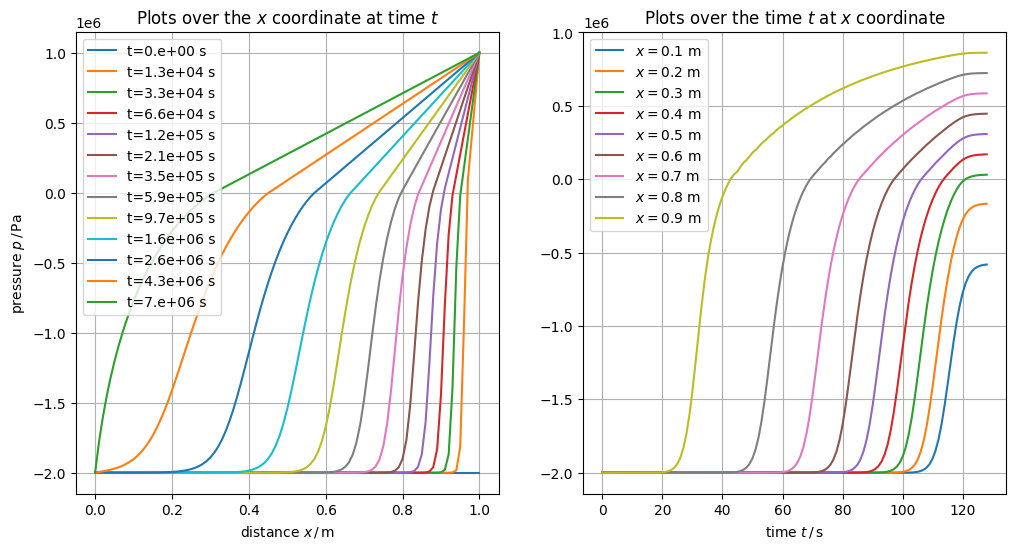

In [42]:
make_transient_plots(times_lookup_table, solution_time_step)

### Variation: Source term

In [43]:
def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Left boundary: Set entire first row to 0, then set the diagonal element to 1
    matrix[0, :] = 0
    matrix[0, 0] = 1
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] = -2.0e6   # Left boundary value in MPa
    rhs[-1] = 1.0e6  # Right boundary value in MPa
    
    # Apply mass source term to the volume in the centre of the domain
    rhs[int(len(rhs)/2)] += 1.0e-05 # total mass source in kg/s (Volumetric source: Q_vol = Q_total/l/1m2) 
    return matrix, rhs

In [44]:
run_simulation()

Time Step 1 with global time 1.e+03 s and step size 1.e+03 s
convergence criterion: |dx|= 3.002e+06 ; |x|= 2.001e+07 ; |dx|/|x|= 1.500e-01
convergence criterion: |dx|= 5.345e+05 ; |x|= 1.996e+07 ; |dx|/|x|= 2.677e-02
convergence criterion: |dx|= 2.336e+05 ; |x|= 1.995e+07 ; |dx|/|x|= 1.171e-02
convergence criterion: |dx|= 1.887e+05 ; |x|= 1.994e+07 ; |dx|/|x|= 9.466e-03
convergence criterion: |dx|= 2.843e+05 ; |x|= 1.992e+07 ; |dx|/|x|= 1.427e-02
convergence criterion: |dx|= 2.303e+04 ; |x|= 1.992e+07 ; |dx|/|x|= 1.156e-03
convergence criterion: |dx|= 2.701e+03 ; |x|= 1.992e+07 ; |dx|/|x|= 1.356e-04
convergence criterion: |dx|= 3.771e+02 ; |x|= 1.992e+07 ; |dx|/|x|= 1.893e-05
convergence criterion: |dx|= 5.645e+01 ; |x|= 1.992e+07 ; |dx|/|x|= 2.834e-06
convergence criterion: |dx|= 8.646e+00 ; |x|= 1.992e+07 ; |dx|/|x|= 4.341e-07
Performed 10 iterations in total
Time Step 2 with global time 2.05e+03 s and step size 1.05e+03 s
convergence criterion: |dx|= 7.339e+05 ; |x|= 1.989e+07 ; |dx

convergence criterion: |dx|= 1.322e+04 ; |x|= 1.918e+07 ; |dx|/|x|= 6.892e-04
convergence criterion: |dx|= 6.958e+03 ; |x|= 1.918e+07 ; |dx|/|x|= 3.627e-04
convergence criterion: |dx|= 1.636e+03 ; |x|= 1.918e+07 ; |dx|/|x|= 8.530e-05
convergence criterion: |dx|= 7.969e+02 ; |x|= 1.918e+07 ; |dx|/|x|= 4.155e-05
convergence criterion: |dx|= 5.224e+02 ; |x|= 1.918e+07 ; |dx|/|x|= 2.724e-05
convergence criterion: |dx|= 1.568e+02 ; |x|= 1.918e+07 ; |dx|/|x|= 8.174e-06
convergence criterion: |dx|= 4.616e+01 ; |x|= 1.918e+07 ; |dx|/|x|= 2.407e-06
convergence criterion: |dx|= 3.707e+01 ; |x|= 1.918e+07 ; |dx|/|x|= 1.932e-06
convergence criterion: |dx|= 1.41e+01 ; |x|= 1.918e+07 ; |dx|/|x|= 7.349e-07
Performed 13 iterations in total
Time Step 19 with global time 3.054e+04 s and step size 2.407e+03 s
convergence criterion: |dx|= 2.867e+05 ; |x|= 1.916e+07 ; |dx|/|x|= 1.497e-02
convergence criterion: |dx|= 1.537e+05 ; |x|= 1.914e+07 ; |dx|/|x|= 8.029e-03
convergence criterion: |dx|= 2.79e+04 ; |x

convergence criterion: |dx|= 9.241e+01 ; |x|= 1.879e+07 ; |dx|/|x|= 4.917e-06
convergence criterion: |dx|= 3.917e+01 ; |x|= 1.879e+07 ; |dx|/|x|= 2.084e-06
convergence criterion: |dx|= 1.583e+01 ; |x|= 1.879e+07 ; |dx|/|x|= 8.424e-07
Performed 11 iterations in total
Time Step 27 with global time 5.467e+04 s and step size 3.556e+03 s
convergence criterion: |dx|= 2.893e+05 ; |x|= 1.876e+07 ; |dx|/|x|= 1.542e-02
convergence criterion: |dx|= 1.866e+05 ; |x|= 1.874e+07 ; |dx|/|x|= 9.956e-03
convergence criterion: |dx|= 8.502e+04 ; |x|= 1.874e+07 ; |dx|/|x|= 4.536e-03
convergence criterion: |dx|= 1.502e+04 ; |x|= 1.874e+07 ; |dx|/|x|= 8.017e-04
convergence criterion: |dx|= 6.767e+03 ; |x|= 1.874e+07 ; |dx|/|x|= 3.611e-04
convergence criterion: |dx|= 3.772e+03 ; |x|= 1.874e+07 ; |dx|/|x|= 2.013e-04
convergence criterion: |dx|= 1.007e+03 ; |x|= 1.874e+07 ; |dx|/|x|= 5.374e-05
convergence criterion: |dx|= 2.422e+02 ; |x|= 1.874e+07 ; |dx|/|x|= 1.292e-05
convergence criterion: |dx|= 1.625e+02 ; 

convergence criterion: |dx|= 1.048e+02 ; |x|= 1.825e+07 ; |dx|/|x|= 5.741e-06
convergence criterion: |dx|= 4.172e+01 ; |x|= 1.825e+07 ; |dx|/|x|= 2.286e-06
convergence criterion: |dx|= 1.646e+01 ; |x|= 1.825e+07 ; |dx|/|x|= 9.02e-07
Performed 11 iterations in total
Time Step 36 with global time 9.584e+04 s and step size 5.516e+03 s
convergence criterion: |dx|= 2.971e+05 ; |x|= 1.821e+07 ; |dx|/|x|= 1.632e-02
convergence criterion: |dx|= 1.88e+05 ; |x|= 1.818e+07 ; |dx|/|x|= 1.034e-02
convergence criterion: |dx|= 8.901e+04 ; |x|= 1.818e+07 ; |dx|/|x|= 4.895e-03
convergence criterion: |dx|= 1.75e+04 ; |x|= 1.818e+07 ; |dx|/|x|= 9.625e-04
convergence criterion: |dx|= 6.215e+03 ; |x|= 1.818e+07 ; |dx|/|x|= 3.419e-04
convergence criterion: |dx|= 3.954e+03 ; |x|= 1.818e+07 ; |dx|/|x|= 2.175e-04
convergence criterion: |dx|= 1.08e+03 ; |x|= 1.818e+07 ; |dx|/|x|= 5.939e-05
convergence criterion: |dx|= 2.705e+02 ; |x|= 1.818e+07 ; |dx|/|x|= 1.488e-05
convergence criterion: |dx|= 1.898e+02 ; |x|=

convergence criterion: |dx|= 1.859e+03 ; |x|= 1.810e+07 ; |dx|/|x|= 1.027e-04
convergence criterion: |dx|= 6.104e+02 ; |x|= 1.810e+07 ; |dx|/|x|= 3.372e-05
convergence criterion: |dx|= 2.223e+03 ; |x|= 1.811e+07 ; |dx|/|x|= 1.228e-04
convergence criterion: |dx|= 1.859e+03 ; |x|= 1.810e+07 ; |dx|/|x|= 1.027e-04
convergence criterion: |dx|= 6.104e+02 ; |x|= 1.810e+07 ; |dx|/|x|= 3.372e-05
Max iterations exceeded.
Stopping iteration scheme.
Performed 101 iterations in total
Time Step 38 with global time 1.077e+05 s and step size 6.081e+03 s
convergence criterion: |dx|= 3.016e+05 ; |x|= 1.806e+07 ; |dx|/|x|= 1.67e-02
convergence criterion: |dx|= 1.526e+05 ; |x|= 1.804e+07 ; |dx|/|x|= 8.462e-03
convergence criterion: |dx|= 6.148e+04 ; |x|= 1.804e+07 ; |dx|/|x|= 3.409e-03
convergence criterion: |dx|= 1.43e+04 ; |x|= 1.803e+07 ; |dx|/|x|= 7.93e-04
convergence criterion: |dx|= 2.695e+03 ; |x|= 1.803e+07 ; |dx|/|x|= 1.494e-04
convergence criterion: |dx|= 1.094e+03 ; |x|= 1.803e+07 ; |dx|/|x|= 6

convergence criterion: |dx|= 1.099e+02 ; |x|= 1.734e+07 ; |dx|/|x|= 6.338e-06
convergence criterion: |dx|= 4.409e+01 ; |x|= 1.734e+07 ; |dx|/|x|= 2.542e-06
convergence criterion: |dx|= 1.810e+01 ; |x|= 1.734e+07 ; |dx|/|x|= 1.044e-06
convergence criterion: |dx|= 8.423e+00 ; |x|= 1.734e+07 ; |dx|/|x|= 4.857e-07
Performed 12 iterations in total
Time Step 47 with global time 1.781e+05 s and step size 9.434e+03 s
convergence criterion: |dx|= 3.254e+05 ; |x|= 1.728e+07 ; |dx|/|x|= 1.884e-02
convergence criterion: |dx|= 1.893e+05 ; |x|= 1.725e+07 ; |dx|/|x|= 1.097e-02
convergence criterion: |dx|= 8.564e+04 ; |x|= 1.725e+07 ; |dx|/|x|= 4.965e-03
convergence criterion: |dx|= 2.455e+04 ; |x|= 1.724e+07 ; |dx|/|x|= 1.424e-03
convergence criterion: |dx|= 4.622e+03 ; |x|= 1.724e+07 ; |dx|/|x|= 2.681e-04
convergence criterion: |dx|= 3.977e+03 ; |x|= 1.724e+07 ; |dx|/|x|= 2.307e-04
convergence criterion: |dx|= 1.466e+03 ; |x|= 1.724e+07 ; |dx|/|x|= 8.504e-05
convergence criterion: |dx|= 2.816e+02 ; 

convergence criterion: |dx|= 9.497e+00 ; |x|= 1.643e+07 ; |dx|/|x|= 5.78e-07
Performed 12 iterations in total
Time Step 55 with global time 2.727e+05 s and step size 1.394e+04 s
convergence criterion: |dx|= 3.539e+05 ; |x|= 1.635e+07 ; |dx|/|x|= 2.165e-02
convergence criterion: |dx|= 1.942e+05 ; |x|= 1.631e+07 ; |dx|/|x|= 1.191e-02
convergence criterion: |dx|= 8.756e+04 ; |x|= 1.631e+07 ; |dx|/|x|= 5.37e-03
convergence criterion: |dx|= 1.318e+04 ; |x|= 1.630e+07 ; |dx|/|x|= 8.087e-04
convergence criterion: |dx|= 6.383e+03 ; |x|= 1.630e+07 ; |dx|/|x|= 3.916e-04
convergence criterion: |dx|= 3.125e+03 ; |x|= 1.63e+07 ; |dx|/|x|= 1.917e-04
convergence criterion: |dx|= 7.674e+02 ; |x|= 1.63e+07 ; |dx|/|x|= 4.708e-05
convergence criterion: |dx|= 2.509e+02 ; |x|= 1.63e+07 ; |dx|/|x|= 1.539e-05
convergence criterion: |dx|= 1.293e+02 ; |x|= 1.63e+07 ; |dx|/|x|= 7.930e-06
convergence criterion: |dx|= 5.002e+01 ; |x|= 1.63e+07 ; |dx|/|x|= 3.069e-06
convergence criterion: |dx|= 2.111e+01 ; |x|= 1.

convergence criterion: |dx|= 9.325e+04 ; |x|= 1.504e+07 ; |dx|/|x|= 6.200e-03
convergence criterion: |dx|= 2.626e+04 ; |x|= 1.503e+07 ; |dx|/|x|= 1.746e-03
convergence criterion: |dx|= 5.328e+03 ; |x|= 1.503e+07 ; |dx|/|x|= 3.544e-04
convergence criterion: |dx|= 4.392e+03 ; |x|= 1.503e+07 ; |dx|/|x|= 2.922e-04
convergence criterion: |dx|= 1.512e+03 ; |x|= 1.503e+07 ; |dx|/|x|= 1.006e-04
convergence criterion: |dx|= 3.043e+02 ; |x|= 1.503e+07 ; |dx|/|x|= 2.024e-05
convergence criterion: |dx|= 2.163e+02 ; |x|= 1.503e+07 ; |dx|/|x|= 1.439e-05
convergence criterion: |dx|= 7.947e+01 ; |x|= 1.503e+07 ; |dx|/|x|= 5.287e-06
convergence criterion: |dx|= 2.069e+01 ; |x|= 1.503e+07 ; |dx|/|x|= 1.376e-06
convergence criterion: |dx|= 1.197e+01 ; |x|= 1.503e+07 ; |dx|/|x|= 7.962e-07
Performed 12 iterations in total
Time Step 64 with global time 4.341e+05 s and step size 2.162e+04 s
convergence criterion: |dx|= 4.026e+05 ; |x|= 1.491e+07 ; |dx|/|x|= 2.701e-02
convergence criterion: |dx|= 2.120e+05 ; 

convergence criterion: |dx|= 7.618e+01 ; |x|= 1.343e+07 ; |dx|/|x|= 5.670e-06
convergence criterion: |dx|= 1.429e+01 ; |x|= 1.343e+07 ; |dx|/|x|= 1.064e-06
convergence criterion: |dx|= 9.729e+00 ; |x|= 1.343e+07 ; |dx|/|x|= 7.242e-07
Performed 12 iterations in total
Time Step 72 with global time 6.509e+05 s and step size 3.195e+04 s
convergence criterion: |dx|= 4.920e+05 ; |x|= 1.328e+07 ; |dx|/|x|= 3.705e-02
convergence criterion: |dx|= 2.461e+05 ; |x|= 1.324e+07 ; |dx|/|x|= 1.86e-02
convergence criterion: |dx|= 1.106e+05 ; |x|= 1.324e+07 ; |dx|/|x|= 8.356e-03
convergence criterion: |dx|= 2.789e+04 ; |x|= 1.323e+07 ; |dx|/|x|= 2.107e-03
convergence criterion: |dx|= 6.342e+03 ; |x|= 1.323e+07 ; |dx|/|x|= 4.793e-04
convergence criterion: |dx|= 3.083e+03 ; |x|= 1.323e+07 ; |dx|/|x|= 2.33e-04
convergence criterion: |dx|= 7.322e+02 ; |x|= 1.323e+07 ; |dx|/|x|= 5.534e-05
convergence criterion: |dx|= 1.745e+02 ; |x|= 1.323e+07 ; |dx|/|x|= 1.319e-05
convergence criterion: |dx|= 8.628e+01 ; |x

convergence criterion: |dx|= 2.534e+03 ; |x|= 1.181e+07 ; |dx|/|x|= 2.146e-04
convergence criterion: |dx|= 1.027e+03 ; |x|= 1.181e+07 ; |dx|/|x|= 8.696e-05
convergence criterion: |dx|= 4.376e+02 ; |x|= 1.181e+07 ; |dx|/|x|= 3.705e-05
convergence criterion: |dx|= 1.812e+02 ; |x|= 1.181e+07 ; |dx|/|x|= 1.535e-05
convergence criterion: |dx|= 7.13e+01 ; |x|= 1.181e+07 ; |dx|/|x|= 6.037e-06
convergence criterion: |dx|= 2.779e+01 ; |x|= 1.181e+07 ; |dx|/|x|= 2.353e-06
convergence criterion: |dx|= 1.106e+01 ; |x|= 1.181e+07 ; |dx|/|x|= 9.364e-07
Performed 13 iterations in total
Time Step 81 with global time 1.021e+06 s and step size 4.956e+04 s
convergence criterion: |dx|= 9.777e+05 ; |x|= 1.177e+07 ; |dx|/|x|= 8.307e-02
convergence criterion: |dx|= 2.874e+05 ; |x|= 1.171e+07 ; |dx|/|x|= 2.453e-02
convergence criterion: |dx|= 9.386e+04 ; |x|= 1.171e+07 ; |dx|/|x|= 8.017e-03
convergence criterion: |dx|= 3.701e+04 ; |x|= 1.170e+07 ; |dx|/|x|= 3.163e-03
convergence criterion: |dx|= 1.181e+04 ; |

convergence criterion: |dx|= 8.807e+02 ; |x|= 1.153e+07 ; |dx|/|x|= 7.640e-05
convergence criterion: |dx|= 1.12e+03 ; |x|= 1.153e+07 ; |dx|/|x|= 9.712e-05
convergence criterion: |dx|= 3.802e+02 ; |x|= 1.153e+07 ; |dx|/|x|= 3.299e-05
convergence criterion: |dx|= 4.411e+01 ; |x|= 1.153e+07 ; |dx|/|x|= 3.827e-06
convergence criterion: |dx|= 3.927e+01 ; |x|= 1.153e+07 ; |dx|/|x|= 3.406e-06
convergence criterion: |dx|= 1.777e+01 ; |x|= 1.153e+07 ; |dx|/|x|= 1.541e-06
convergence criterion: |dx|= 3.901e+00 ; |x|= 1.153e+07 ; |dx|/|x|= 3.385e-07
Performed 14 iterations in total
Time Step 89 with global time 1.518e+06 s and step size 7.322e+04 s
convergence criterion: |dx|= 1.533e+06 ; |x|= 1.191e+07 ; |dx|/|x|= 1.287e-01
convergence criterion: |dx|= 1.199e+06 ; |x|= 1.129e+07 ; |dx|/|x|= 1.062e-01
convergence criterion: |dx|= 4.613e+05 ; |x|= 1.147e+07 ; |dx|/|x|= 4.021e-02
convergence criterion: |dx|= 1.225e+05 ; |x|= 1.141e+07 ; |dx|/|x|= 1.074e-02
convergence criterion: |dx|= 4.815e+04 ; |

convergence criterion: |dx|= 3.066e+03 ; |x|= 1.111e+07 ; |dx|/|x|= 2.760e-04
convergence criterion: |dx|= 2.706e+03 ; |x|= 1.110e+07 ; |dx|/|x|= 2.436e-04
convergence criterion: |dx|= 1.465e+03 ; |x|= 1.111e+07 ; |dx|/|x|= 1.319e-04
convergence criterion: |dx|= 8.615e+02 ; |x|= 1.111e+07 ; |dx|/|x|= 7.757e-05
convergence criterion: |dx|= 2.631e+03 ; |x|= 1.110e+07 ; |dx|/|x|= 2.37e-04
convergence criterion: |dx|= 3.066e+03 ; |x|= 1.111e+07 ; |dx|/|x|= 2.760e-04
convergence criterion: |dx|= 2.705e+03 ; |x|= 1.110e+07 ; |dx|/|x|= 2.436e-04
convergence criterion: |dx|= 1.465e+03 ; |x|= 1.111e+07 ; |dx|/|x|= 1.319e-04
convergence criterion: |dx|= 8.615e+02 ; |x|= 1.111e+07 ; |dx|/|x|= 7.757e-05
convergence criterion: |dx|= 2.631e+03 ; |x|= 1.110e+07 ; |dx|/|x|= 2.37e-04
convergence criterion: |dx|= 3.066e+03 ; |x|= 1.111e+07 ; |dx|/|x|= 2.760e-04
convergence criterion: |dx|= 2.705e+03 ; |x|= 1.110e+07 ; |dx|/|x|= 2.436e-04
convergence criterion: |dx|= 1.465e+03 ; |x|= 1.111e+07 ; |dx|/|x|

convergence criterion: |dx|= 5.721e+05 ; |x|= 1.091e+07 ; |dx|/|x|= 5.244e-02
convergence criterion: |dx|= 1.686e+05 ; |x|= 1.08e+07 ; |dx|/|x|= 1.562e-02
convergence criterion: |dx|= 5.887e+04 ; |x|= 1.076e+07 ; |dx|/|x|= 5.471e-03
convergence criterion: |dx|= 3.521e+04 ; |x|= 1.078e+07 ; |dx|/|x|= 3.265e-03
convergence criterion: |dx|= 7.209e+03 ; |x|= 1.078e+07 ; |dx|/|x|= 6.688e-04
convergence criterion: |dx|= 1.369e+03 ; |x|= 1.078e+07 ; |dx|/|x|= 1.270e-04
convergence criterion: |dx|= 1.229e+03 ; |x|= 1.078e+07 ; |dx|/|x|= 1.14e-04
convergence criterion: |dx|= 3.07e+02 ; |x|= 1.078e+07 ; |dx|/|x|= 2.848e-05
convergence criterion: |dx|= 2.795e+01 ; |x|= 1.078e+07 ; |dx|/|x|= 2.593e-06
convergence criterion: |dx|= 3.818e+01 ; |x|= 1.078e+07 ; |dx|/|x|= 3.542e-06
convergence criterion: |dx|= 1.124e+01 ; |x|= 1.078e+07 ; |dx|/|x|= 1.043e-06
convergence criterion: |dx|= 6.348e-01 ; |x|= 1.078e+07 ; |dx|/|x|= 5.889e-08
Performed 14 iterations in total
Time Step 99 with global time 2.48

convergence criterion: |dx|= 2.676e+04 ; |x|= 1.113e+07 ; |dx|/|x|= 2.405e-03
convergence criterion: |dx|= 6.28e+03 ; |x|= 1.112e+07 ; |dx|/|x|= 5.646e-04
convergence criterion: |dx|= 2.431e+03 ; |x|= 1.112e+07 ; |dx|/|x|= 2.186e-04
convergence criterion: |dx|= 2.091e+03 ; |x|= 1.112e+07 ; |dx|/|x|= 1.88e-04
convergence criterion: |dx|= 3.923e+02 ; |x|= 1.112e+07 ; |dx|/|x|= 3.527e-05
convergence criterion: |dx|= 2.791e+02 ; |x|= 1.112e+07 ; |dx|/|x|= 2.509e-05
convergence criterion: |dx|= 1.666e+02 ; |x|= 1.112e+07 ; |dx|/|x|= 1.498e-05
convergence criterion: |dx|= 1.719e+01 ; |x|= 1.112e+07 ; |dx|/|x|= 1.545e-06
convergence criterion: |dx|= 2.970e+01 ; |x|= 1.112e+07 ; |dx|/|x|= 2.671e-06
convergence criterion: |dx|= 1.183e+01 ; |x|= 1.112e+07 ; |dx|/|x|= 1.063e-06
convergence criterion: |dx|= 2.033e+00 ; |x|= 1.112e+07 ; |dx|/|x|= 1.827e-07
Performed 13 iterations in total
Time Step 106 with global time 3.504e+06 s and step size 1.678e+05 s
convergence criterion: |dx|= 1.389e+04 ; |

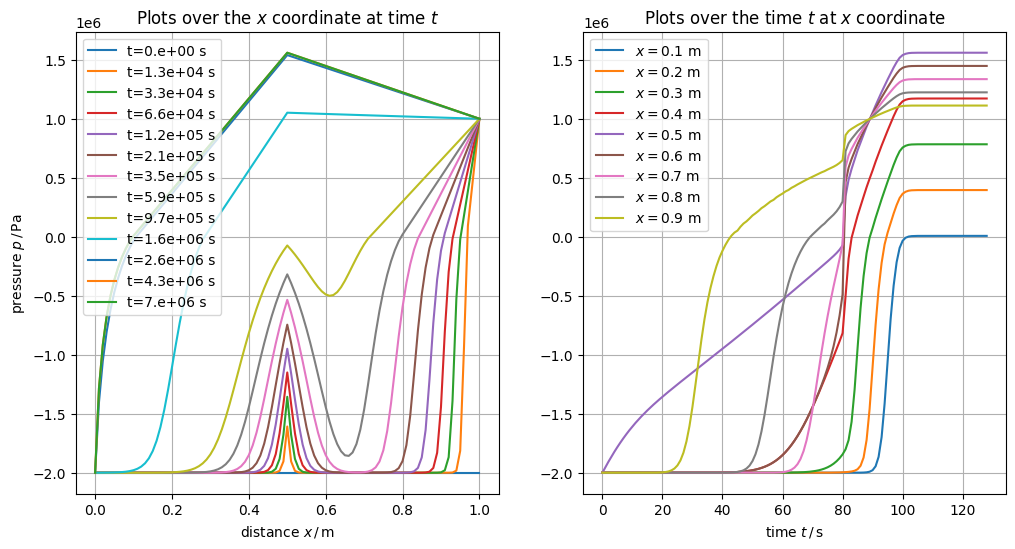

In [45]:
make_transient_plots(times_lookup_table, solution_time_step)

### Variation: Neumann BC

Time Step 1 with global time 1.e+03 s and step size 1.e+03 s
convergence criterion: |dx|= 3.002e+06 ; |x|= 2.001e+07 ; |dx|/|x|= 1.5e-01
convergence criterion: |dx|= 5.345e+05 ; |x|= 1.997e+07 ; |dx|/|x|= 2.677e-02
convergence criterion: |dx|= 2.336e+05 ; |x|= 1.995e+07 ; |dx|/|x|= 1.171e-02
convergence criterion: |dx|= 1.887e+05 ; |x|= 1.994e+07 ; |dx|/|x|= 9.464e-03
convergence criterion: |dx|= 2.843e+05 ; |x|= 1.993e+07 ; |dx|/|x|= 1.427e-02
convergence criterion: |dx|= 2.303e+04 ; |x|= 1.993e+07 ; |dx|/|x|= 1.156e-03
convergence criterion: |dx|= 2.701e+03 ; |x|= 1.992e+07 ; |dx|/|x|= 1.356e-04
convergence criterion: |dx|= 3.771e+02 ; |x|= 1.992e+07 ; |dx|/|x|= 1.892e-05
convergence criterion: |dx|= 5.645e+01 ; |x|= 1.992e+07 ; |dx|/|x|= 2.833e-06
convergence criterion: |dx|= 8.646e+00 ; |x|= 1.992e+07 ; |dx|/|x|= 4.34e-07
Performed 10 iterations in total
Time Step 2 with global time 2.05e+03 s and step size 1.05e+03 s
convergence criterion: |dx|= 7.324e+05 ; |x|= 1.99e+07 ; |dx|/|x

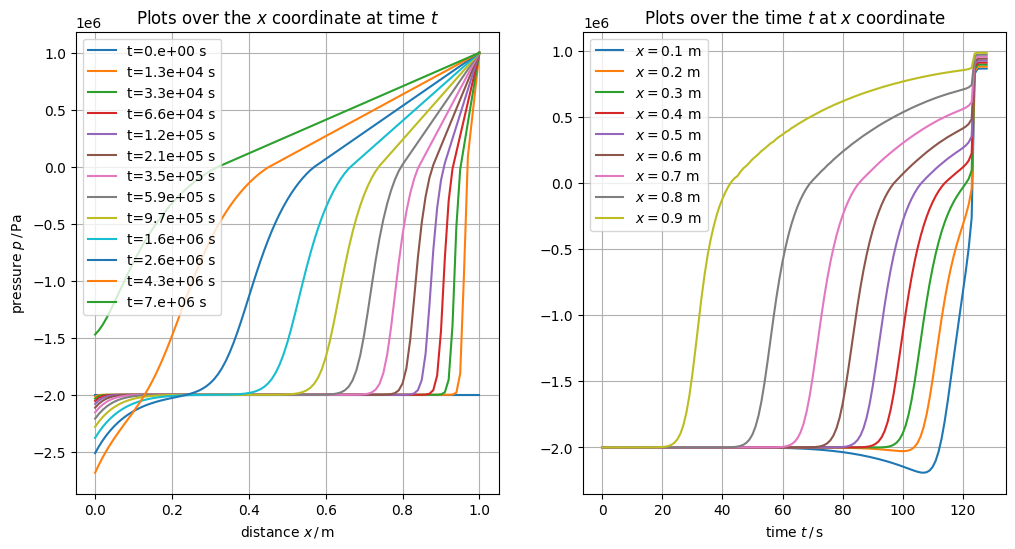

convergence criterion: |dx|= 9.884e+01 ; |x|= 1.888e+07 ; |dx|/|x|= 5.235e-06
convergence criterion: |dx|= 3.885e+01 ; |x|= 1.888e+07 ; |dx|/|x|= 2.058e-06
convergence criterion: |dx|= 1.507e+01 ; |x|= 1.888e+07 ; |dx|/|x|= 7.981e-07
Performed 11 iterations in total
Time Step 36 with global time 9.584e+04 s and step size 5.516e+03 s
convergence criterion: |dx|= 2.896e+05 ; |x|= 1.886e+07 ; |dx|/|x|= 1.535e-02
convergence criterion: |dx|= 1.871e+05 ; |x|= 1.884e+07 ; |dx|/|x|= 9.928e-03
convergence criterion: |dx|= 8.878e+04 ; |x|= 1.885e+07 ; |dx|/|x|= 4.711e-03
convergence criterion: |dx|= 1.732e+04 ; |x|= 1.884e+07 ; |dx|/|x|= 9.192e-04
convergence criterion: |dx|= 6.131e+03 ; |x|= 1.884e+07 ; |dx|/|x|= 3.254e-04
convergence criterion: |dx|= 3.931e+03 ; |x|= 1.884e+07 ; |dx|/|x|= 2.086e-04
convergence criterion: |dx|= 1.064e+03 ; |x|= 1.884e+07 ; |dx|/|x|= 5.646e-05
convergence criterion: |dx|= 2.584e+02 ; |x|= 1.884e+07 ; |dx|/|x|= 1.371e-05
convergence criterion: |dx|= 1.866e+02 ; 

convergence criterion: |dx|= 1.874e+03 ; |x|= 1.881e+07 ; |dx|/|x|= 9.966e-05
convergence criterion: |dx|= 6.154e+02 ; |x|= 1.881e+07 ; |dx|/|x|= 3.272e-05
convergence criterion: |dx|= 2.241e+03 ; |x|= 1.881e+07 ; |dx|/|x|= 1.192e-04
convergence criterion: |dx|= 1.874e+03 ; |x|= 1.881e+07 ; |dx|/|x|= 9.966e-05
convergence criterion: |dx|= 6.154e+02 ; |x|= 1.881e+07 ; |dx|/|x|= 3.272e-05
convergence criterion: |dx|= 2.241e+03 ; |x|= 1.881e+07 ; |dx|/|x|= 1.192e-04
convergence criterion: |dx|= 1.874e+03 ; |x|= 1.881e+07 ; |dx|/|x|= 9.966e-05
convergence criterion: |dx|= 6.154e+02 ; |x|= 1.881e+07 ; |dx|/|x|= 3.272e-05
Max iterations exceeded.
Stopping iteration scheme.
Performed 101 iterations in total
Time Step 38 with global time 1.077e+05 s and step size 6.081e+03 s
convergence criterion: |dx|= 2.931e+05 ; |x|= 1.878e+07 ; |dx|/|x|= 1.561e-02
convergence criterion: |dx|= 1.515e+05 ; |x|= 1.877e+07 ; |dx|/|x|= 8.07e-03
convergence criterion: |dx|= 6.112e+04 ; |x|= 1.877e+07 ; |dx|/|x|=

convergence criterion: |dx|= 1.710e+01 ; |x|= 1.849e+07 ; |dx|/|x|= 9.251e-07
Performed 11 iterations in total
Time Step 46 with global time 1.687e+05 s and step size 8.985e+03 s
convergence criterion: |dx|= 3.059e+05 ; |x|= 1.846e+07 ; |dx|/|x|= 1.657e-02
convergence criterion: |dx|= 1.672e+05 ; |x|= 1.844e+07 ; |dx|/|x|= 9.064e-03
convergence criterion: |dx|= 6.976e+04 ; |x|= 1.844e+07 ; |dx|/|x|= 3.782e-03
convergence criterion: |dx|= 1.125e+04 ; |x|= 1.844e+07 ; |dx|/|x|= 6.1e-04
convergence criterion: |dx|= 5.212e+03 ; |x|= 1.844e+07 ; |dx|/|x|= 2.826e-04
convergence criterion: |dx|= 2.635e+03 ; |x|= 1.844e+07 ; |dx|/|x|= 1.429e-04
convergence criterion: |dx|= 6.7e+02 ; |x|= 1.844e+07 ; |dx|/|x|= 3.633e-05
convergence criterion: |dx|= 1.954e+02 ; |x|= 1.844e+07 ; |dx|/|x|= 1.059e-05
convergence criterion: |dx|= 1.042e+02 ; |x|= 1.844e+07 ; |dx|/|x|= 5.653e-06
convergence criterion: |dx|= 4.198e+01 ; |x|= 1.844e+07 ; |dx|/|x|= 2.276e-06
convergence criterion: |dx|= 1.755e+01 ; |x|=

convergence criterion: |dx|= 1.861e+05 ; |x|= 1.805e+07 ; |dx|/|x|= 1.031e-02
convergence criterion: |dx|= 8.072e+04 ; |x|= 1.806e+07 ; |dx|/|x|= 4.471e-03
convergence criterion: |dx|= 2.596e+04 ; |x|= 1.805e+07 ; |dx|/|x|= 1.438e-03
convergence criterion: |dx|= 4.263e+03 ; |x|= 1.805e+07 ; |dx|/|x|= 2.361e-04
convergence criterion: |dx|= 1.967e+03 ; |x|= 1.805e+07 ; |dx|/|x|= 1.09e-04
convergence criterion: |dx|= 5.819e+02 ; |x|= 1.805e+07 ; |dx|/|x|= 3.224e-05
convergence criterion: |dx|= 2.029e+02 ; |x|= 1.805e+07 ; |dx|/|x|= 1.124e-05
convergence criterion: |dx|= 9.421e+01 ; |x|= 1.805e+07 ; |dx|/|x|= 5.219e-06
convergence criterion: |dx|= 4.440e+01 ; |x|= 1.805e+07 ; |dx|/|x|= 2.46e-06
convergence criterion: |dx|= 2.142e+01 ; |x|= 1.805e+07 ; |dx|/|x|= 1.187e-06
convergence criterion: |dx|= 1.061e+01 ; |x|= 1.805e+07 ; |dx|/|x|= 5.877e-07
Performed 12 iterations in total
Time Step 55 with global time 2.727e+05 s and step size 1.394e+04 s
convergence criterion: |dx|= 3.314e+05 ; |x

convergence criterion: |dx|= 1.676e+04 ; |x|= 1.759e+07 ; |dx|/|x|= 9.532e-04
convergence criterion: |dx|= 3.277e+03 ; |x|= 1.759e+07 ; |dx|/|x|= 1.863e-04
convergence criterion: |dx|= 1.898e+03 ; |x|= 1.759e+07 ; |dx|/|x|= 1.08e-04
convergence criterion: |dx|= 6.559e+02 ; |x|= 1.759e+07 ; |dx|/|x|= 3.73e-05
convergence criterion: |dx|= 2.4e+02 ; |x|= 1.759e+07 ; |dx|/|x|= 1.364e-05
convergence criterion: |dx|= 1.176e+02 ; |x|= 1.759e+07 ; |dx|/|x|= 6.687e-06
convergence criterion: |dx|= 5.776e+01 ; |x|= 1.759e+07 ; |dx|/|x|= 3.284e-06
convergence criterion: |dx|= 2.921e+01 ; |x|= 1.759e+07 ; |dx|/|x|= 1.661e-06
convergence criterion: |dx|= 1.529e+01 ; |x|= 1.759e+07 ; |dx|/|x|= 8.692e-07
Performed 12 iterations in total
Time Step 63 with global time 4.125e+05 s and step size 2.059e+04 s
convergence criterion: |dx|= 3.597e+05 ; |x|= 1.755e+07 ; |dx|/|x|= 2.05e-02
convergence criterion: |dx|= 2.056e+05 ; |x|= 1.752e+07 ; |dx|/|x|= 1.173e-02
convergence criterion: |dx|= 9.196e+04 ; |x|= 

convergence criterion: |dx|= 1.336e+01 ; |x|= 1.710e+07 ; |dx|/|x|= 7.809e-07
Performed 13 iterations in total
Time Step 70 with global time 5.885e+05 s and step size 2.898e+04 s
convergence criterion: |dx|= 3.872e+05 ; |x|= 1.706e+07 ; |dx|/|x|= 2.27e-02
convergence criterion: |dx|= 2.231e+05 ; |x|= 1.703e+07 ; |dx|/|x|= 1.310e-02
convergence criterion: |dx|= 1.012e+05 ; |x|= 1.703e+07 ; |dx|/|x|= 5.943e-03
convergence criterion: |dx|= 3.064e+04 ; |x|= 1.703e+07 ; |dx|/|x|= 1.799e-03
convergence criterion: |dx|= 6.074e+03 ; |x|= 1.703e+07 ; |dx|/|x|= 3.567e-04
convergence criterion: |dx|= 2.786e+03 ; |x|= 1.703e+07 ; |dx|/|x|= 1.636e-04
convergence criterion: |dx|= 7.946e+02 ; |x|= 1.703e+07 ; |dx|/|x|= 4.667e-05
convergence criterion: |dx|= 3.098e+02 ; |x|= 1.703e+07 ; |dx|/|x|= 1.819e-05
convergence criterion: |dx|= 1.616e+02 ; |x|= 1.703e+07 ; |dx|/|x|= 9.493e-06
convergence criterion: |dx|= 8.453e+01 ; |x|= 1.703e+07 ; |dx|/|x|= 4.965e-06
convergence criterion: |dx|= 4.595e+01 ; |

convergence criterion: |dx|= 7.104e+01 ; |x|= 1.654e+07 ; |dx|/|x|= 4.296e-06
convergence criterion: |dx|= 4.139e+01 ; |x|= 1.654e+07 ; |dx|/|x|= 2.503e-06
convergence criterion: |dx|= 2.425e+01 ; |x|= 1.654e+07 ; |dx|/|x|= 1.466e-06
convergence criterion: |dx|= 1.427e+01 ; |x|= 1.654e+07 ; |dx|/|x|= 8.629e-07
Performed 14 iterations in total
Time Step 77 with global time 8.363e+05 s and step size 4.077e+04 s
convergence criterion: |dx|= 4.195e+05 ; |x|= 1.648e+07 ; |dx|/|x|= 2.545e-02
convergence criterion: |dx|= 2.481e+05 ; |x|= 1.645e+07 ; |dx|/|x|= 1.509e-02
convergence criterion: |dx|= 1.177e+05 ; |x|= 1.645e+07 ; |dx|/|x|= 7.156e-03
convergence criterion: |dx|= 3.258e+04 ; |x|= 1.645e+07 ; |dx|/|x|= 1.981e-03
convergence criterion: |dx|= 7.559e+03 ; |x|= 1.645e+07 ; |dx|/|x|= 4.596e-04
convergence criterion: |dx|= 3.337e+03 ; |x|= 1.645e+07 ; |dx|/|x|= 2.029e-04
convergence criterion: |dx|= 9.662e+02 ; |x|= 1.645e+07 ; |dx|/|x|= 5.874e-05
convergence criterion: |dx|= 4.263e+02 ; 

convergence criterion: |dx|= 4.908e+01 ; |x|= 1.588e+07 ; |dx|/|x|= 3.091e-06
convergence criterion: |dx|= 3.022e+01 ; |x|= 1.588e+07 ; |dx|/|x|= 1.903e-06
convergence criterion: |dx|= 1.863e+01 ; |x|= 1.588e+07 ; |dx|/|x|= 1.173e-06
convergence criterion: |dx|= 1.149e+01 ; |x|= 1.588e+07 ; |dx|/|x|= 7.235e-07
Performed 16 iterations in total
Time Step 84 with global time 1.185e+06 s and step size 5.737e+04 s
convergence criterion: |dx|= 4.536e+05 ; |x|= 1.581e+07 ; |dx|/|x|= 2.868e-02
convergence criterion: |dx|= 2.563e+05 ; |x|= 1.577e+07 ; |dx|/|x|= 1.625e-02
convergence criterion: |dx|= 1.158e+05 ; |x|= 1.578e+07 ; |dx|/|x|= 7.34e-03
convergence criterion: |dx|= 3.538e+04 ; |x|= 1.577e+07 ; |dx|/|x|= 2.243e-03
convergence criterion: |dx|= 6.660e+03 ; |x|= 1.577e+07 ; |dx|/|x|= 4.222e-04
convergence criterion: |dx|= 6.241e+03 ; |x|= 1.578e+07 ; |dx|/|x|= 3.956e-04
convergence criterion: |dx|= 2.447e+03 ; |x|= 1.578e+07 ; |dx|/|x|= 1.551e-04
convergence criterion: |dx|= 7.371e+02 ; |

convergence criterion: |dx|= 3.592e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 2.341e-05
convergence criterion: |dx|= 1.438e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 9.373e-06
convergence criterion: |dx|= 4.675e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 3.046e-05
convergence criterion: |dx|= 3.592e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 2.341e-05
convergence criterion: |dx|= 1.438e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 9.372e-06
convergence criterion: |dx|= 4.675e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 3.046e-05
convergence criterion: |dx|= 3.592e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 2.341e-05
convergence criterion: |dx|= 1.438e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 9.372e-06
convergence criterion: |dx|= 4.675e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 3.046e-05
convergence criterion: |dx|= 3.592e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 2.340e-05
convergence criterion: |dx|= 1.438e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 9.372e-06
convergence criterion: |dx|= 4.675e+02 ; |x|= 1.535e+07 ; |dx|/|x|= 3.046e-05
convergence criterion: |dx|= 3.592e+02 ; |x|= 1.535e+07 ; |dx|/|

convergence criterion: |dx|= 4.572e+02 ; |x|= 1.500e+07 ; |dx|/|x|= 3.047e-05
convergence criterion: |dx|= 2.970e+02 ; |x|= 1.501e+07 ; |dx|/|x|= 1.979e-05
convergence criterion: |dx|= 1.937e+02 ; |x|= 1.501e+07 ; |dx|/|x|= 1.291e-05
convergence criterion: |dx|= 1.264e+02 ; |x|= 1.501e+07 ; |dx|/|x|= 8.422e-06
convergence criterion: |dx|= 8.251e+01 ; |x|= 1.501e+07 ; |dx|/|x|= 5.499e-06
convergence criterion: |dx|= 5.387e+01 ; |x|= 1.501e+07 ; |dx|/|x|= 3.590e-06
convergence criterion: |dx|= 3.518e+01 ; |x|= 1.501e+07 ; |dx|/|x|= 2.344e-06
convergence criterion: |dx|= 2.297e+01 ; |x|= 1.501e+07 ; |dx|/|x|= 1.531e-06
convergence criterion: |dx|= 1.5e+01 ; |x|= 1.501e+07 ; |dx|/|x|= 9.994e-07
Performed 18 iterations in total
Time Step 92 with global time 1.760e+06 s and step size 8.477e+04 s
convergence criterion: |dx|= 4.993e+05 ; |x|= 1.493e+07 ; |dx|/|x|= 3.345e-02
convergence criterion: |dx|= 2.896e+05 ; |x|= 1.488e+07 ; |dx|/|x|= 1.947e-02
convergence criterion: |dx|= 1.36e+05 ; |x|

convergence criterion: |dx|= 7.667e+01 ; |x|= 1.439e+07 ; |dx|/|x|= 5.328e-06
convergence criterion: |dx|= 5.222e+01 ; |x|= 1.439e+07 ; |dx|/|x|= 3.63e-06
convergence criterion: |dx|= 3.557e+01 ; |x|= 1.439e+07 ; |dx|/|x|= 2.472e-06
convergence criterion: |dx|= 2.423e+01 ; |x|= 1.439e+07 ; |dx|/|x|= 1.684e-06
convergence criterion: |dx|= 1.65e+01 ; |x|= 1.439e+07 ; |dx|/|x|= 1.147e-06
convergence criterion: |dx|= 1.124e+01 ; |x|= 1.439e+07 ; |dx|/|x|= 7.809e-07
Performed 21 iterations in total
Time Step 97 with global time 2.252e+06 s and step size 1.082e+05 s
convergence criterion: |dx|= 5.267e+05 ; |x|= 1.43e+07 ; |dx|/|x|= 3.684e-02
convergence criterion: |dx|= 2.997e+05 ; |x|= 1.424e+07 ; |dx|/|x|= 2.104e-02
convergence criterion: |dx|= 1.37e+05 ; |x|= 1.425e+07 ; |dx|/|x|= 9.609e-03
convergence criterion: |dx|= 3.819e+04 ; |x|= 1.425e+07 ; |dx|/|x|= 2.680e-03
convergence criterion: |dx|= 9.354e+03 ; |x|= 1.425e+07 ; |dx|/|x|= 6.565e-04
convergence criterion: |dx|= 5.343e+03 ; |x|=

convergence criterion: |dx|= 9.879e+01 ; |x|= 1.366e+07 ; |dx|/|x|= 7.231e-06
convergence criterion: |dx|= 7.038e+01 ; |x|= 1.366e+07 ; |dx|/|x|= 5.152e-06
convergence criterion: |dx|= 5.014e+01 ; |x|= 1.366e+07 ; |dx|/|x|= 3.670e-06
convergence criterion: |dx|= 3.573e+01 ; |x|= 1.366e+07 ; |dx|/|x|= 2.615e-06
convergence criterion: |dx|= 2.546e+01 ; |x|= 1.366e+07 ; |dx|/|x|= 1.863e-06
convergence criterion: |dx|= 1.814e+01 ; |x|= 1.366e+07 ; |dx|/|x|= 1.328e-06
convergence criterion: |dx|= 1.293e+01 ; |x|= 1.366e+07 ; |dx|/|x|= 9.463e-07
Performed 23 iterations in total
Time Step 102 with global time 2.88e+06 s and step size 1.381e+05 s
convergence criterion: |dx|= 5.529e+05 ; |x|= 1.355e+07 ; |dx|/|x|= 4.081e-02
convergence criterion: |dx|= 3.173e+05 ; |x|= 1.348e+07 ; |dx|/|x|= 2.355e-02
convergence criterion: |dx|= 1.457e+05 ; |x|= 1.349e+07 ; |dx|/|x|= 1.080e-02
convergence criterion: |dx|= 4.044e+04 ; |x|= 1.348e+07 ; |dx|/|x|= 3.000e-03
convergence criterion: |dx|= 9.684e+03 ; 

convergence criterion: |dx|= 1.666e+01 ; |x|= 1.255e+07 ; |dx|/|x|= 1.328e-06
convergence criterion: |dx|= 1.211e+01 ; |x|= 1.255e+07 ; |dx|/|x|= 9.653e-07
Performed 23 iterations in total
Time Step 107 with global time 3.681e+06 s and step size 1.762e+05 s
convergence criterion: |dx|= 5.763e+05 ; |x|= 1.238e+07 ; |dx|/|x|= 4.654e-02
convergence criterion: |dx|= 3.337e+05 ; |x|= 1.227e+07 ; |dx|/|x|= 2.72e-02
convergence criterion: |dx|= 1.541e+05 ; |x|= 1.227e+07 ; |dx|/|x|= 1.256e-02
convergence criterion: |dx|= 4.387e+04 ; |x|= 1.224e+07 ; |dx|/|x|= 3.583e-03
convergence criterion: |dx|= 1.240e+04 ; |x|= 1.223e+07 ; |dx|/|x|= 1.014e-03
convergence criterion: |dx|= 7.708e+03 ; |x|= 1.223e+07 ; |dx|/|x|= 6.304e-04
convergence criterion: |dx|= 4.529e+03 ; |x|= 1.222e+07 ; |dx|/|x|= 3.705e-04
convergence criterion: |dx|= 3.121e+03 ; |x|= 1.222e+07 ; |dx|/|x|= 2.554e-04
convergence criterion: |dx|= 2.239e+03 ; |x|= 1.222e+07 ; |dx|/|x|= 1.832e-04
convergence criterion: |dx|= 1.619e+03 ; 

convergence criterion: |dx|= 3.556e+05 ; |x|= 1.047e+07 ; |dx|/|x|= 3.396e-02
convergence criterion: |dx|= 1.713e+05 ; |x|= 1.044e+07 ; |dx|/|x|= 1.641e-02
convergence criterion: |dx|= 6.032e+04 ; |x|= 1.04e+07 ; |dx|/|x|= 5.801e-03
convergence criterion: |dx|= 2.867e+04 ; |x|= 1.037e+07 ; |dx|/|x|= 2.764e-03
convergence criterion: |dx|= 1.834e+04 ; |x|= 1.036e+07 ; |dx|/|x|= 1.770e-03
convergence criterion: |dx|= 1.149e+04 ; |x|= 1.035e+07 ; |dx|/|x|= 1.11e-03
convergence criterion: |dx|= 7.333e+03 ; |x|= 1.035e+07 ; |dx|/|x|= 7.086e-04
convergence criterion: |dx|= 4.675e+03 ; |x|= 1.035e+07 ; |dx|/|x|= 4.518e-04
convergence criterion: |dx|= 2.971e+03 ; |x|= 1.034e+07 ; |dx|/|x|= 2.872e-04
convergence criterion: |dx|= 1.885e+03 ; |x|= 1.034e+07 ; |dx|/|x|= 1.822e-04
convergence criterion: |dx|= 1.195e+03 ; |x|= 1.034e+07 ; |dx|/|x|= 1.155e-04
convergence criterion: |dx|= 7.567e+02 ; |x|= 1.034e+07 ; |dx|/|x|= 7.317e-05
convergence criterion: |dx|= 4.791e+02 ; |x|= 1.034e+07 ; |dx|/|x|

convergence criterion: |dx|= 2.466e+01 ; |x|= 6.83e+06 ; |dx|/|x|= 3.611e-06
convergence criterion: |dx|= 4.990e+00 ; |x|= 6.83e+06 ; |dx|/|x|= 7.306e-07
Performed 11 iterations in total
Time Step 118 with global time 6.309e+06 s and step size 3.014e+05 s
convergence criterion: |dx|= 7.383e+05 ; |x|= 6.523e+06 ; |dx|/|x|= 1.132e-01
convergence criterion: |dx|= 3.982e+05 ; |x|= 6.331e+06 ; |dx|/|x|= 6.29e-02
convergence criterion: |dx|= 1.798e+05 ; |x|= 6.383e+06 ; |dx|/|x|= 2.816e-02
convergence criterion: |dx|= 4.969e+04 ; |x|= 6.361e+06 ; |dx|/|x|= 7.812e-03
convergence criterion: |dx|= 8.226e+03 ; |x|= 6.359e+06 ; |dx|/|x|= 1.294e-03
convergence criterion: |dx|= 7.090e+03 ; |x|= 6.362e+06 ; |dx|/|x|= 1.114e-03
convergence criterion: |dx|= 1.801e+03 ; |x|= 6.361e+06 ; |dx|/|x|= 2.831e-04
convergence criterion: |dx|= 3.182e+02 ; |x|= 6.361e+06 ; |dx|/|x|= 5.003e-05
convergence criterion: |dx|= 2.63e+02 ; |x|= 6.361e+06 ; |dx|/|x|= 4.134e-05
convergence criterion: |dx|= 6.179e+01 ; |x|

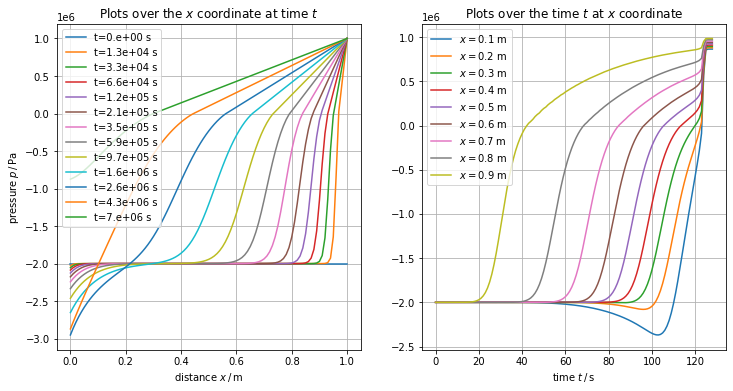

In [46]:
def apply_BCs(matrix, rhs):
    # Prescribe Dirichlet BCs at the first (0-th) and last volume (boundaries)
    
    # Right boundary: Set entire last row to 0, then set the diagonal element to 1
    matrix[-1, :] = 0
    matrix[-1, -1] = 1
    
    # Apply Dirichlet boundary conditions to the rhs vector
    rhs[0] += - 3e-07  # Left flow rate value in MPa
    rhs[-1] = 1.0e6  # Right boundary value in MPa
    
    return matrix, rhs

run_simulation()
make_transient_plots(times_lookup_table, solution_time_step)

### Variation 3: Sealed BC, but more complex IC:
Let us discuss the following questions:
* Why does the pressure in the initially fully liquid saturated region decrease so much faster than the pressure increases in initially unsaturated regions?
* What happens when we increase the end time to, say, 2.5e8 s? What should happen physically and what happens numerically?

Time Step 1 with global time 1.e+03 s and step size 1.e+03 s
convergence criterion: |dx|= 6.666e+06 ; |x|= 1.486e+07 ; |dx|/|x|= 4.487e-01
convergence criterion: |dx|= 6.618e+06 ; |x|= 1.582e+07 ; |dx|/|x|= 4.185e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.486e+07 ; |dx|/|x|= 4.478e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.582e+07 ; |dx|/|x|= 4.207e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.486e+07 ; |dx|/|x|= 4.477e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.582e+07 ; |dx|/|x|= 4.207e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.486e+07 ; |dx|/|x|= 4.477e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.582e+07 ; |dx|/|x|= 4.207e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.486e+07 ; |dx|/|x|= 4.477e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.582e+07 ; |dx|/|x|= 4.207e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.486e+07 ; |dx|/|x|= 4.477e-01
convergence criterion: |dx|= 6.654e+06 ; |x|= 1.582e+07 ; |dx|/|x|= 4.207e-01
con

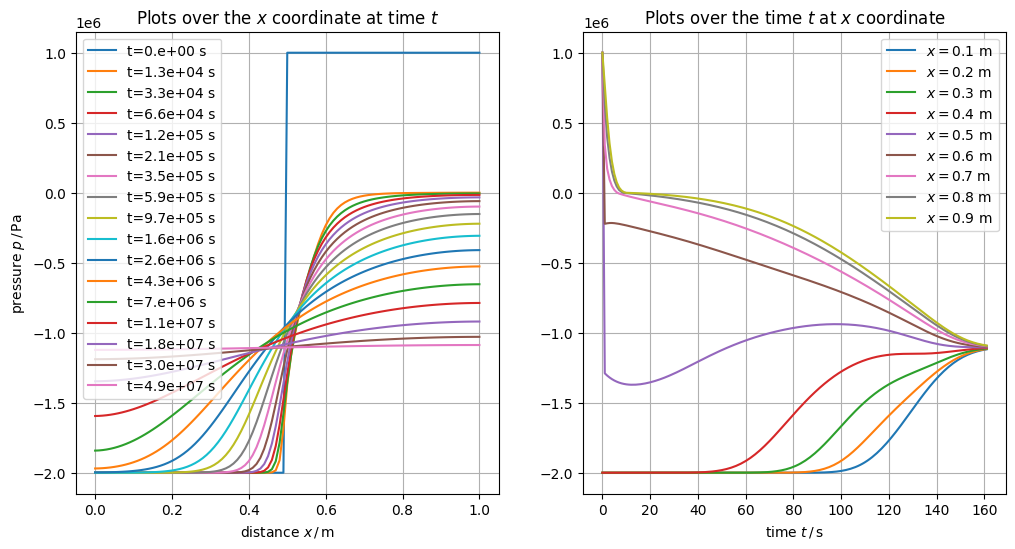

convergence criterion: |dx|= 5.294e+04 ; |x|= 1.36e+07 ; |dx|/|x|= 3.894e-03
convergence criterion: |dx|= 1.974e+04 ; |x|= 1.359e+07 ; |dx|/|x|= 1.452e-03
convergence criterion: |dx|= 8.260e+03 ; |x|= 1.359e+07 ; |dx|/|x|= 6.078e-04
convergence criterion: |dx|= 3.667e+03 ; |x|= 1.359e+07 ; |dx|/|x|= 2.699e-04
convergence criterion: |dx|= 1.661e+03 ; |x|= 1.359e+07 ; |dx|/|x|= 1.222e-04
convergence criterion: |dx|= 7.664e+02 ; |x|= 1.359e+07 ; |dx|/|x|= 5.640e-05
convergence criterion: |dx|= 3.569e+02 ; |x|= 1.359e+07 ; |dx|/|x|= 2.626e-05
convergence criterion: |dx|= 1.676e+02 ; |x|= 1.359e+07 ; |dx|/|x|= 1.233e-05
convergence criterion: |dx|= 7.907e+01 ; |x|= 1.359e+07 ; |dx|/|x|= 5.819e-06
convergence criterion: |dx|= 3.747e+01 ; |x|= 1.359e+07 ; |dx|/|x|= 2.758e-06
convergence criterion: |dx|= 1.781e+01 ; |x|= 1.359e+07 ; |dx|/|x|= 1.311e-06
convergence criterion: |dx|= 8.486e+00 ; |x|= 1.359e+07 ; |dx|/|x|= 6.245e-07
Performed 12 iterations in total
Time Step 35 with global time 9.

convergence criterion: |dx|= 3.901e+01 ; |x|= 1.344e+07 ; |dx|/|x|= 2.903e-06
convergence criterion: |dx|= 1.853e+01 ; |x|= 1.344e+07 ; |dx|/|x|= 1.379e-06
convergence criterion: |dx|= 8.815e+00 ; |x|= 1.344e+07 ; |dx|/|x|= 6.558e-07
Performed 12 iterations in total
Time Step 43 with global time 1.43e+05 s and step size 7.762e+03 s
convergence criterion: |dx|= 5.522e+04 ; |x|= 1.343e+07 ; |dx|/|x|= 4.112e-03
convergence criterion: |dx|= 2.061e+04 ; |x|= 1.342e+07 ; |dx|/|x|= 1.536e-03
convergence criterion: |dx|= 8.643e+03 ; |x|= 1.342e+07 ; |dx|/|x|= 6.44e-04
convergence criterion: |dx|= 3.839e+03 ; |x|= 1.342e+07 ; |dx|/|x|= 2.860e-04
convergence criterion: |dx|= 1.740e+03 ; |x|= 1.342e+07 ; |dx|/|x|= 1.297e-04
convergence criterion: |dx|= 8.035e+02 ; |x|= 1.342e+07 ; |dx|/|x|= 5.988e-05
convergence criterion: |dx|= 3.744e+02 ; |x|= 1.342e+07 ; |dx|/|x|= 2.79e-05
convergence criterion: |dx|= 1.758e+02 ; |x|= 1.342e+07 ; |dx|/|x|= 1.310e-05
convergence criterion: |dx|= 8.296e+01 ; |x|

convergence criterion: |dx|= 8.623e+02 ; |x|= 1.324e+07 ; |dx|/|x|= 6.513e-05
convergence criterion: |dx|= 4.011e+02 ; |x|= 1.324e+07 ; |dx|/|x|= 3.03e-05
convergence criterion: |dx|= 1.879e+02 ; |x|= 1.324e+07 ; |dx|/|x|= 1.419e-05
convergence criterion: |dx|= 8.834e+01 ; |x|= 1.324e+07 ; |dx|/|x|= 6.672e-06
convergence criterion: |dx|= 4.165e+01 ; |x|= 1.324e+07 ; |dx|/|x|= 3.146e-06
convergence criterion: |dx|= 1.967e+01 ; |x|= 1.324e+07 ; |dx|/|x|= 1.486e-06
convergence criterion: |dx|= 9.301e+00 ; |x|= 1.324e+07 ; |dx|/|x|= 7.025e-07
Performed 12 iterations in total
Time Step 52 with global time 2.329e+05 s and step size 1.204e+04 s
convergence criterion: |dx|= 5.942e+04 ; |x|= 1.323e+07 ; |dx|/|x|= 4.493e-03
convergence criterion: |dx|= 2.227e+04 ; |x|= 1.322e+07 ; |dx|/|x|= 1.685e-03
convergence criterion: |dx|= 9.362e+03 ; |x|= 1.322e+07 ; |dx|/|x|= 7.083e-04
convergence criterion: |dx|= 4.162e+03 ; |x|= 1.322e+07 ; |dx|/|x|= 3.149e-04
convergence criterion: |dx|= 1.887e+03 ; |

convergence criterion: |dx|= 4.285e+02 ; |x|= 1.302e+07 ; |dx|/|x|= 3.290e-05
convergence criterion: |dx|= 1.99e+02 ; |x|= 1.302e+07 ; |dx|/|x|= 1.528e-05
convergence criterion: |dx|= 9.266e+01 ; |x|= 1.302e+07 ; |dx|/|x|= 7.115e-06
convergence criterion: |dx|= 4.323e+01 ; |x|= 1.302e+07 ; |dx|/|x|= 3.319e-06
convergence criterion: |dx|= 2.018e+01 ; |x|= 1.302e+07 ; |dx|/|x|= 1.550e-06
convergence criterion: |dx|= 9.430e+00 ; |x|= 1.302e+07 ; |dx|/|x|= 7.241e-07
Performed 12 iterations in total
Time Step 60 with global time 3.536e+05 s and step size 1.779e+04 s
convergence criterion: |dx|= 6.451e+04 ; |x|= 1.300e+07 ; |dx|/|x|= 4.961e-03
convergence criterion: |dx|= 2.426e+04 ; |x|= 1.3e+07 ; |dx|/|x|= 1.866e-03
convergence criterion: |dx|= 1.02e+04 ; |x|= 1.299e+07 ; |dx|/|x|= 7.849e-04
convergence criterion: |dx|= 4.522e+03 ; |x|= 1.299e+07 ; |dx|/|x|= 3.480e-04
convergence criterion: |dx|= 2.041e+03 ; |x|= 1.299e+07 ; |dx|/|x|= 1.571e-04
convergence criterion: |dx|= 9.353e+02 ; |x|=

convergence criterion: |dx|= 1.196e+04 ; |x|= 1.239e+07 ; |dx|/|x|= 9.652e-04
convergence criterion: |dx|= 5.137e+03 ; |x|= 1.239e+07 ; |dx|/|x|= 4.146e-04
convergence criterion: |dx|= 2.236e+03 ; |x|= 1.239e+07 ; |dx|/|x|= 1.805e-04
convergence criterion: |dx|= 9.833e+02 ; |x|= 1.239e+07 ; |dx|/|x|= 7.938e-05
convergence criterion: |dx|= 4.343e+02 ; |x|= 1.239e+07 ; |dx|/|x|= 3.506e-05
convergence criterion: |dx|= 1.925e+02 ; |x|= 1.239e+07 ; |dx|/|x|= 1.554e-05
convergence criterion: |dx|= 8.554e+01 ; |x|= 1.239e+07 ; |dx|/|x|= 6.905e-06
convergence criterion: |dx|= 3.808e+01 ; |x|= 1.239e+07 ; |dx|/|x|= 3.074e-06
convergence criterion: |dx|= 1.698e+01 ; |x|= 1.239e+07 ; |dx|/|x|= 1.371e-06
convergence criterion: |dx|= 7.592e+00 ; |x|= 1.239e+07 ; |dx|/|x|= 6.129e-07
Performed 12 iterations in total
Time Step 77 with global time 8.363e+05 s and step size 4.077e+04 s
convergence criterion: |dx|= 7.901e+04 ; |x|= 1.236e+07 ; |dx|/|x|= 6.392e-03
convergence criterion: |dx|= 2.940e+04 ; 

convergence criterion: |dx|= 5.205e+03 ; |x|= 1.192e+07 ; |dx|/|x|= 4.367e-04
convergence criterion: |dx|= 2.177e+03 ; |x|= 1.192e+07 ; |dx|/|x|= 1.826e-04
convergence criterion: |dx|= 9.203e+02 ; |x|= 1.192e+07 ; |dx|/|x|= 7.721e-05
convergence criterion: |dx|= 3.916e+02 ; |x|= 1.192e+07 ; |dx|/|x|= 3.285e-05
convergence criterion: |dx|= 1.677e+02 ; |x|= 1.192e+07 ; |dx|/|x|= 1.407e-05
convergence criterion: |dx|= 7.231e+01 ; |x|= 1.192e+07 ; |dx|/|x|= 6.066e-06
convergence criterion: |dx|= 3.141e+01 ; |x|= 1.192e+07 ; |dx|/|x|= 2.635e-06
convergence criterion: |dx|= 1.376e+01 ; |x|= 1.192e+07 ; |dx|/|x|= 1.154e-06
convergence criterion: |dx|= 6.083e+00 ; |x|= 1.192e+07 ; |dx|/|x|= 5.103e-07
Performed 12 iterations in total
Time Step 86 with global time 1.308e+06 s and step size 6.325e+04 s
convergence criterion: |dx|= 8.812e+04 ; |x|= 1.189e+07 ; |dx|/|x|= 7.414e-03
convergence criterion: |dx|= 3.199e+04 ; |x|= 1.187e+07 ; |dx|/|x|= 2.695e-03
convergence criterion: |dx|= 1.265e+04 ; 

convergence criterion: |dx|= 1.285e+04 ; |x|= 1.133e+07 ; |dx|/|x|= 1.134e-03
convergence criterion: |dx|= 5.065e+03 ; |x|= 1.133e+07 ; |dx|/|x|= 4.471e-04
convergence criterion: |dx|= 2.038e+03 ; |x|= 1.133e+07 ; |dx|/|x|= 1.799e-04
convergence criterion: |dx|= 8.368e+02 ; |x|= 1.133e+07 ; |dx|/|x|= 7.388e-05
convergence criterion: |dx|= 3.503e+02 ; |x|= 1.133e+07 ; |dx|/|x|= 3.093e-05
convergence criterion: |dx|= 1.497e+02 ; |x|= 1.133e+07 ; |dx|/|x|= 1.322e-05
convergence criterion: |dx|= 6.524e+01 ; |x|= 1.133e+07 ; |dx|/|x|= 5.760e-06
convergence criterion: |dx|= 2.896e+01 ; |x|= 1.133e+07 ; |dx|/|x|= 2.557e-06
convergence criterion: |dx|= 1.307e+01 ; |x|= 1.133e+07 ; |dx|/|x|= 1.154e-06
convergence criterion: |dx|= 5.971e+00 ; |x|= 1.133e+07 ; |dx|/|x|= 5.272e-07
Performed 12 iterations in total
Time Step 95 with global time 2.041e+06 s and step size 9.813e+04 s
convergence criterion: |dx|= 9.778e+04 ; |x|= 1.128e+07 ; |dx|/|x|= 8.665e-03
convergence criterion: |dx|= 3.413e+04 ; 

convergence criterion: |dx|= 3.146e+02 ; |x|= 1.068e+07 ; |dx|/|x|= 2.946e-05
convergence criterion: |dx|= 1.307e+02 ; |x|= 1.068e+07 ; |dx|/|x|= 1.224e-05
convergence criterion: |dx|= 5.498e+01 ; |x|= 1.068e+07 ; |dx|/|x|= 5.149e-06
convergence criterion: |dx|= 2.333e+01 ; |x|= 1.068e+07 ; |dx|/|x|= 2.185e-06
convergence criterion: |dx|= 9.964e+00 ; |x|= 1.068e+07 ; |dx|/|x|= 9.332e-07
Performed 11 iterations in total
Time Step 103 with global time 3.025e+06 s and step size 1.45e+05 s
convergence criterion: |dx|= 1.083e+05 ; |x|= 1.063e+07 ; |dx|/|x|= 1.019e-02
convergence criterion: |dx|= 3.624e+04 ; |x|= 1.060e+07 ; |dx|/|x|= 3.418e-03
convergence criterion: |dx|= 1.303e+04 ; |x|= 1.059e+07 ; |dx|/|x|= 1.229e-03
convergence criterion: |dx|= 4.892e+03 ; |x|= 1.059e+07 ; |dx|/|x|= 4.619e-04
convergence criterion: |dx|= 1.89e+03 ; |x|= 1.059e+07 ; |dx|/|x|= 1.785e-04
convergence criterion: |dx|= 7.481e+02 ; |x|= 1.059e+07 ; |dx|/|x|= 7.065e-05
convergence criterion: |dx|= 3.020e+02 ; |

convergence criterion: |dx|= 3.548e+03 ; |x|= 9.775e+06 ; |dx|/|x|= 3.629e-04
convergence criterion: |dx|= 1.126e+03 ; |x|= 9.775e+06 ; |dx|/|x|= 1.152e-04
convergence criterion: |dx|= 3.6e+02 ; |x|= 9.774e+06 ; |dx|/|x|= 3.683e-05
convergence criterion: |dx|= 1.156e+02 ; |x|= 9.774e+06 ; |dx|/|x|= 1.183e-05
convergence criterion: |dx|= 3.727e+01 ; |x|= 9.774e+06 ; |dx|/|x|= 3.813e-06
convergence criterion: |dx|= 1.205e+01 ; |x|= 9.774e+06 ; |dx|/|x|= 1.233e-06
convergence criterion: |dx|= 3.911e+00 ; |x|= 9.774e+06 ; |dx|/|x|= 4.001e-07
Performed 10 iterations in total
Time Step 113 with global time 4.939e+06 s and step size 2.362e+05 s
convergence criterion: |dx|= 1.257e+05 ; |x|= 9.723e+06 ; |dx|/|x|= 1.293e-02
convergence criterion: |dx|= 3.621e+04 ; |x|= 9.694e+06 ; |dx|/|x|= 3.735e-03
convergence criterion: |dx|= 1.083e+04 ; |x|= 9.69e+06 ; |dx|/|x|= 1.118e-03
convergence criterion: |dx|= 3.302e+03 ; |x|= 9.687e+06 ; |dx|/|x|= 3.409e-04
convergence criterion: |dx|= 1.013e+03 ; |x

convergence criterion: |dx|= 2.479e+00 ; |x|= 8.941e+06 ; |dx|/|x|= 2.773e-07
Performed 8 iterations in total
Time Step 124 with global time 8.462e+06 s and step size 4.039e+05 s
convergence criterion: |dx|= 1.331e+05 ; |x|= 8.903e+06 ; |dx|/|x|= 1.495e-02
convergence criterion: |dx|= 2.504e+04 ; |x|= 8.884e+06 ; |dx|/|x|= 2.819e-03
convergence criterion: |dx|= 4.891e+03 ; |x|= 8.884e+06 ; |dx|/|x|= 5.505e-04
convergence criterion: |dx|= 9.901e+02 ; |x|= 8.883e+06 ; |dx|/|x|= 1.115e-04
convergence criterion: |dx|= 2.050e+02 ; |x|= 8.883e+06 ; |dx|/|x|= 2.308e-05
convergence criterion: |dx|= 4.317e+01 ; |x|= 8.883e+06 ; |dx|/|x|= 4.860e-06
convergence criterion: |dx|= 9.189e+00 ; |x|= 8.883e+06 ; |dx|/|x|= 1.034e-06
convergence criterion: |dx|= 1.969e+00 ; |x|= 8.883e+06 ; |dx|/|x|= 2.216e-07
Performed 8 iterations in total
Time Step 125 with global time 8.886e+06 s and step size 4.241e+05 s
convergence criterion: |dx|= 1.323e+05 ; |x|= 8.848e+06 ; |dx|/|x|= 1.495e-02
convergence criter

convergence criterion: |dx|= 1.031e+03 ; |x|= 8.423e+06 ; |dx|/|x|= 1.224e-04
convergence criterion: |dx|= 1.299e+02 ; |x|= 8.423e+06 ; |dx|/|x|= 1.542e-05
convergence criterion: |dx|= 1.634e+01 ; |x|= 8.423e+06 ; |dx|/|x|= 1.941e-06
convergence criterion: |dx|= 2.056e+00 ; |x|= 8.423e+06 ; |dx|/|x|= 2.441e-07
Performed 6 iterations in total
Time Step 139 with global time 1.761e+07 s and step size 8.397e+05 s
convergence criterion: |dx|= 9.077e+04 ; |x|= 8.414e+06 ; |dx|/|x|= 1.079e-02
convergence criterion: |dx|= 7.589e+03 ; |x|= 8.409e+06 ; |dx|/|x|= 9.024e-04
convergence criterion: |dx|= 8.985e+02 ; |x|= 8.41e+06 ; |dx|/|x|= 1.068e-04
convergence criterion: |dx|= 1.081e+02 ; |x|= 8.41e+06 ; |dx|/|x|= 1.285e-05
convergence criterion: |dx|= 1.300e+01 ; |x|= 8.41e+06 ; |dx|/|x|= 1.546e-06
convergence criterion: |dx|= 1.563e+00 ; |x|= 8.41e+06 ; |dx|/|x|= 1.859e-07
Performed 6 iterations in total
Time Step 140 with global time 1.85e+07 s and step size 8.817e+05 s
convergence criterion: 

convergence criterion: |dx|= 6.315e+02 ; |x|= 8.35e+06 ; |dx|/|x|= 7.563e-05
convergence criterion: |dx|= 3.417e+01 ; |x|= 8.35e+06 ; |dx|/|x|= 4.093e-06
convergence criterion: |dx|= 1.869e+00 ; |x|= 8.35e+06 ; |dx|/|x|= 2.238e-07
Performed 4 iterations in total
Time Step 159 with global time 4.677e+07 s and step size 2.228e+06 s
convergence criterion: |dx|= 9.757e+03 ; |x|= 8.35e+06 ; |dx|/|x|= 1.169e-03
convergence criterion: |dx|= 5.178e+02 ; |x|= 8.35e+06 ; |dx|/|x|= 6.202e-05
convergence criterion: |dx|= 2.763e+01 ; |x|= 8.35e+06 ; |dx|/|x|= 3.309e-06
convergence criterion: |dx|= 1.485e+00 ; |x|= 8.35e+06 ; |dx|/|x|= 1.778e-07
Performed 4 iterations in total
Time Step 160 with global time 4.911e+07 s and step size 2.339e+06 s
convergence criterion: |dx|= 8.007e+03 ; |x|= 8.35e+06 ; |dx|/|x|= 9.589e-04
convergence criterion: |dx|= 4.201e+02 ; |x|= 8.35e+06 ; |dx|/|x|= 5.031e-05
convergence criterion: |dx|= 2.212e+01 ; |x|= 8.35e+06 ; |dx|/|x|= 2.649e-06
convergence criterion: |dx|=

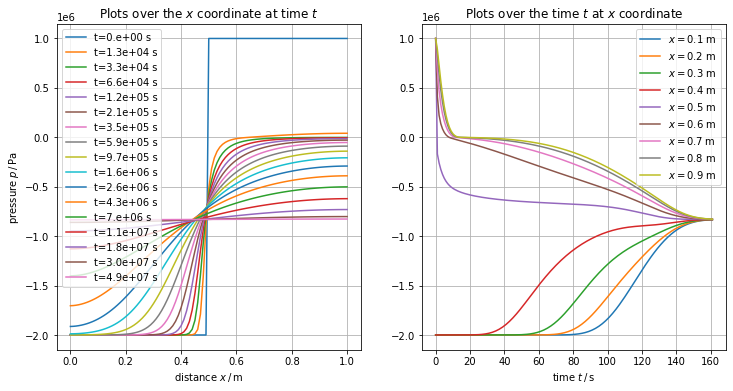

In [47]:
def apply_BCs(matrix, rhs):
    # doing nothing is equivalent to Neumann zero-flux BCs at both boundaries
    return matrix, rhs

def run_simulation():
    L = 1.0 # length of 1D domain in m
    num_volumes = 101 # discretisation into N volumes
    l = L/(num_volumes - 1) # distance between centres of two neighbouring volumes
    global solution_time_step
    global times_lookup_table
    times_lookup_table = {}
    solution_time_step = {}
    times_lookup_table = {}
    global_time = 0.0 # initialize starting time
    dt = 1.0e03 # initial time step size
    end_time = 5.0e07 #3600*24*365/6 # 1 year
    ts = 0 # time step counter
    solution_time_step[ts] = np.append(np.linspace(-2e6,-2e6,50), np.linspace(1e6,1e6,51)) # initial pressure vector
    times_lookup_table[ts] = global_time     # and global time dictionary
    while global_time < end_time:     # Loop for each time step
        ts = ts+1 # increase time step counter
        global_time = global_time + dt # increase time tracker
        print("Time Step", ts, \
              "with global time", np.format_float_scientific(global_time, precision=3), \
              "s and step size", np.format_float_scientific(dt, precision=3), "s")
        solution_time_step[ts] = iterate_solution(solution_time_step[ts-1], dt) # solve equation system for this time step
        times_lookup_table[ts] = global_time # save the time corresponding to this time step
        dt = dt*1.05 # increase time step size for next step if desired
    print("Finito :-)!")
    
run_simulation()
make_transient_plots(times_lookup_table, solution_time_step)